# Labo III
# Multinacional - Prediccion de Ventas

## Importamos librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer



# Optional for larger text and better visuals
sns.set(style="whitegrid", context="talk")

ModuleNotFoundError: No module named 'pandas'

In [2]:
## Importamos datasets

In [2]:
# Load the sales data (tab-delimited)
sales = pd.read_csv("../datasets/sell-in.txt", sep="\t", dtype={"periodo": str})

# Load the stocks data (tab-delimited)
stocks = pd.read_csv("../datasets/tb_stocks.txt", sep="\t", dtype={"periodo": str})

# Load the product information data (tab-delimited)
product_info = pd.read_csv("../datasets/tb_productos.txt", sep="\t")

In [3]:
sales['periodo'] = pd.to_datetime(sales['periodo'], format='%Y%m')
stocks['periodo'] = pd.to_datetime(stocks['periodo'], format='%Y%m')

In [4]:
# MONTHLY SALES

# Group by month and product, summing total sales in tons
monthly_sales = (
    sales.groupby(['periodo', 'product_id','customer_id'])['tn']
    .sum()
    .reset_index()
)


# Dealing with zeros

In [5]:
# Ordenar el DataFrame por periodo, product_id y customer_id
monthly_sales = monthly_sales.sort_values(['periodo', 'product_id', 'customer_id'])

# Crear un DataFrame con todas las combinaciones posibles de periodo, product_id y customer_id
all_periods = monthly_sales['periodo'].drop_duplicates()
all_products = monthly_sales['product_id'].drop_duplicates()
all_customers = monthly_sales['customer_id'].drop_duplicates()

full_index = pd.MultiIndex.from_product(
    [all_periods, all_products, all_customers],
    names=['periodo', 'product_id', 'customer_id']
)

# Crear un DataFrame completo con todas las combinaciones
full_sales = pd.DataFrame(index=full_index).reset_index()

# Fusionar con las ventas originales
full_sales = full_sales.merge(monthly_sales, on=['periodo', 'product_id', 'customer_id'], how='left')

# Encontrar la primera y última compra para cada combinación de producto y cliente
first_last_purchase = monthly_sales.groupby(['product_id', 'customer_id']).agg({
    'periodo': ['min', 'max']
}).reset_index()
first_last_purchase.columns = ['product_id', 'customer_id', 'first_purchase', 'last_purchase']

# Fusionar esta información con full_sales
full_sales = full_sales.merge(first_last_purchase, on=['product_id', 'customer_id'], how='left')

# Aplicar la lógica de llenado
def fill_logic(row):
    if pd.isnull(row['tn']):
        if row['periodo'] >= row['first_purchase'] and row['periodo'] <= row['last_purchase']:
            return 0
    return row['tn']

full_sales['tn'] = full_sales.apply(fill_logic, axis=1)

# Eliminar filas donde no hay ventas y están fuera del rango de compra
full_sales = full_sales[
    (~full_sales['tn'].isnull()) | 
    ((full_sales['periodo'] >= full_sales['first_purchase']) & 
     (full_sales['periodo'] <= full_sales['last_purchase']))
]

# Limpiar columnas temporales y ordenar el resultado
full_sales = full_sales.drop(['first_purchase', 'last_purchase'], axis=1)
full_sales = full_sales.sort_values(['periodo', 'product_id', 'customer_id'])

# Rellenar los NaN restantes con 0
full_sales['tn'] = full_sales['tn'].fillna(0)

In [6]:
# Merge stock_final into full_sales
data = full_sales.merge(stocks, on=['periodo', 'product_id'], how='left')

# Merge product info (static features)
data = data.merge(product_info, on='product_id', how='left')

C:\Users\s1093678\AppData\Local\Temp\ipykernel_32836\3572993996.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['periodo'] = pd.to_datetime(filtered_df['periodo'])


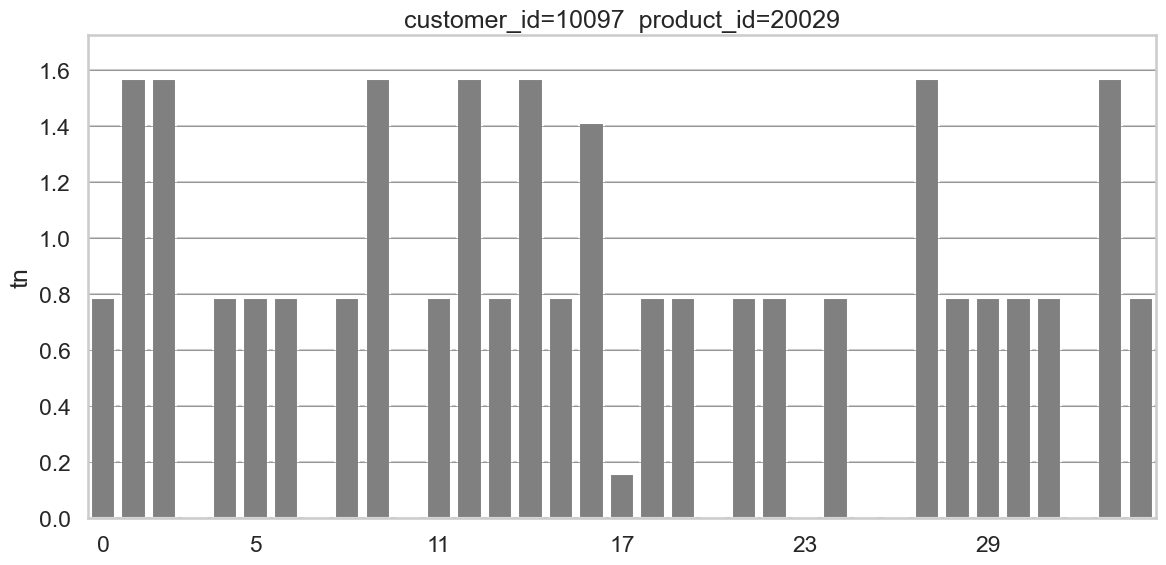

In [7]:
customer_id = 10097
product_id = 20029

filtered_df = full_sales[(full_sales['customer_id'] == customer_id) & (full_sales['product_id'] == product_id)]

# Convert 'periodo' to datetime if it's not already
filtered_df['periodo'] = pd.to_datetime(filtered_df['periodo'])

# Sort the DataFrame by date
filtered_df = filtered_df.sort_values('periodo')

# Reset index to get a range index for x-axis
filtered_df = filtered_df.reset_index(drop=True)

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=filtered_df.index, y='tn', data=filtered_df, color='gray')

# Customize the plot
plt.title(f'customer_id={customer_id}  product_id={product_id}')
plt.xlabel('')
plt.ylabel('tn')

# Remove x-axis labels
plt.xticks([])

# Add x-axis ticks at 0 and every 6th position
x_ticks = [0] + list(range(5, len(filtered_df), 6))
plt.xticks(x_ticks, [str(x) for x in x_ticks])

# Set y-axis limits
plt.ylim(0, filtered_df['tn'].max() * 1.1)  # Set the upper limit to 110% of the max value

# Add horizontal lines
for y in np.arange(0.2, plt.ylim()[1], 0.2):
    plt.axhline(y=y, color='gray', linestyle='-', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
data.head()

,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,10001,99.43861,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
1,2017-01-01,20001,10002,35.72806,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
2,2017-01-01,20001,10003,143.49426,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
3,2017-01-01,20001,10004,184.72927,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
4,2017-01-01,20001,10005,19.08407,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0


# Adding some random columns



In [11]:
data.head()

,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,10001,99.43861,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
1,2017-01-01,20001,10002,35.72806,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
2,2017-01-01,20001,10003,143.49426,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
3,2017-01-01,20001,10004,184.72927,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
4,2017-01-01,20001,10005,19.08407,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0


In [8]:
# 1. --- TEMPORALES Y FECHAS ---
data['year'] = data['periodo'].dt.year
data['month'] = data['periodo'].dt.month
data['quarter'] = data['periodo'].dt.quarter
data['day_of_week'] = data['periodo'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['is_month_start'] = data['periodo'].dt.is_month_start.astype(int)
data['is_month_end'] = data['periodo'].dt.is_month_end.astype(int)

# 2. --- LAGS Y ROLLINGS ---
for lag in range(1, 13):
    data[f'sales_lag_{lag}'] = data.groupby(['product_id', 'customer_id'])['tn'].shift(lag)

windows = [3, 6, 12]
for window in windows:
    data[f'sales_rolling_mean_{window}'] = data.groupby(['product_id', 'customer_id'])['tn'].transform(lambda x: x.rolling(window).mean())
    data[f'sales_rolling_std_{window}'] = data.groupby(['product_id', 'customer_id'])['tn'].transform(lambda x: x.rolling(window).std())
    data[f'sales_ewma_{window}'] = data.groupby(['product_id', 'customer_id'])['tn'].transform(lambda x: x.ewm(span=window).mean())

# 3. --- ACUMULADOS Y ESTADÍSTICAS ---
data['cumulative_sales'] = data.groupby(['product_id', 'customer_id'])['tn'].cumsum()

# 4. --- FEATURES DE PRODUCTO Y CLIENTE ---
data['product_customer_combined'] = data['product_id'].astype(str) + '_' + data['customer_id'].astype(str)

for cat in ['product_id', 'customer_id', 'brand', 'cat1', 'cat2', 'cat3']:
    if cat in data.columns:
        data[f'{cat}_mean'] = data.groupby(cat)['tn'].transform('mean')
        data[f'{cat}_std'] = data.groupby(cat)['tn'].transform('std')
        data[f'{cat}_max'] = data.groupby(cat)['tn'].transform('max')
        data[f'{cat}_median'] = data.groupby(cat)['tn'].transform('median')
        data[f'{cat}_min'] = data.groupby(cat)['tn'].transform('min')
        data[f'{cat}_q25'] = data.groupby(cat)['tn'].transform(lambda x: x.quantile(0.25))
        data[f'{cat}_q75'] = data.groupby(cat)['tn'].transform(lambda x: x.quantile(0.75))

# 5. --- SEASONALITY (CICLOS) ---
data['sin_month'] = np.sin(2 * np.pi * data['month'] / 12)
data['cos_month'] = np.cos(2 * np.pi * data['month'] / 12)

# 6. --- FEATURES RELATIVAS ---
data['sales_relative_to_product_mean'] = data['tn'] / (data['product_id_mean'] + 1e-6)
data['sales_relative_to_customer_mean'] = data['tn'] / (data['customer_id_mean'] + 1e-6)

# 7. --- STOCKS ---
data['stock_turnover'] = data['tn'] / (data['stock_final'] + 1e-6)
data['days_of_stock'] = np.where(data['stock_final'] > 0, data['stock_final'] / (data['tn'] + 1e-6) * 30, np.nan)

# 8. --- AGREGADOS POR CATEGORÍA Y MARCA ---
for col in ['cat1', 'cat2', 'cat3', 'brand', 'sku_size']:
    if col in data.columns:
        data[f'{col}_avg_sales'] = data.groupby(col)['tn'].transform('mean')

# 9. --- DIFERENCIAS Y VARIACIONES ---
data['sales_diff'] = data.groupby(['product_id', 'customer_id'])['tn'].diff()
data['sales_pct_change'] = data.groupby(['product_id', 'customer_id'])['tn'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
data['yoy_growth'] = data.groupby(['product_id', 'customer_id'])['tn'].pct_change(periods=12)

# 10. --- FRECUENCIA DE COMPRA Y ANTIGÜEDAD ---
purchase_counts = data.groupby(['product_id', 'customer_id'])['tn'].apply(lambda x: (x > 0).sum())
active_months = data.groupby(['product_id', 'customer_id'])['tn'].count()
purchase_frequency = purchase_counts / active_months
purchase_frequency = purchase_frequency.rename('purchase_frequency').reset_index()
data = data.merge(purchase_frequency, on=['product_id', 'customer_id'], how='left')

data['days_since_first_purchase'] = (data['periodo'] - data.groupby(['product_id', 'customer_id'])['periodo'].transform('min')).dt.days
data['days_since_last_purchase'] = (data.groupby(['product_id', 'customer_id'])['periodo'].transform('max') - data['periodo']).dt.days

# 11. --- CICLO DE VIDA DEL PRODUCTO ---
# Calculate product age in months using year and month difference
min_period = data.groupby('product_id')['periodo'].transform('min')
data['product_age_months'] = (data['periodo'].dt.year - min_period.dt.year) * 12 + (data['periodo'].dt.month - min_period.dt.month)
data['product_lifecycle_stage'] = pd.cut(
    data['product_age_months'],
    bins=[-1, 2, 12, 1000],
    labels=['Nuevo', 'Crecimiento', 'Maduro']
)
data['is_new_product'] = (data['product_age_months'] < 3).astype(int)
data['is_long_lived_product'] = (data['product_age_months'] > 24).astype(int)

# 12. --- VENTAS FAMILIARES ---
data['family_total_sales'] = data.groupby(['cat1', 'periodo'])['tn'].transform('sum')
data['product_vs_family_sales'] = data['tn'] / data['family_total_sales'].replace(0, np.nan)
data['family_sales_trend'] = data.groupby('cat1')['family_total_sales'].diff()

# 13. --- FEATURES DE INTERACCIÓN ---
data['freq_lag1_interaction'] = data['purchase_frequency'] * data['sales_lag_1']

# 14. --- LEALTAD DEL CLIENTE ---
data['customer_tenure'] = (data.groupby('customer_id')['periodo'].transform('max') - data.groupby('customer_id')['periodo'].transform('min')).dt.days

# 15. --- LIMPIEZA FINAL ---
data = data.replace([np.inf, -np.inf], np.nan)
# Fix for Categorical columns: add 0 to categories before fillna
for col in data.select_dtypes(include='category').columns:
	if 0 not in data[col].cat.categories:
		data[col] = data[col].cat.add_categories([0])
data = data.fillna(0)

print("Feature engineering terminado. Shape final:", data.shape)
data.head()

Feature engineering terminado. Shape final: (6585163, 108)


,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size,...,days_since_last_purchase,product_age_months,product_lifecycle_stage,is_new_product,is_long_lived_product,family_total_sales,product_vs_family_sales,family_sales_trend,freq_lag1_interaction,customer_tenure
0,2017-01-01,20001,10001,99.43861,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,0.004585,0.0,0.0,1064
1,2017-01-01,20001,10002,35.72806,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,0.001647,0.0,0.0,1064
2,2017-01-01,20001,10003,143.49426,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,0.006617,0.0,0.0,1064
3,2017-01-01,20001,10004,184.72927,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,0.008518,0.0,0.0,1064
4,2017-01-01,20001,10005,19.08407,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,0.000880,0.0,0.0,1064


In [14]:
data

,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size,...,days_since_last_purchase,product_age_months,product_lifecycle_stage,is_new_product,is_long_lived_product,family_total_sales,product_vs_family_sales,family_sales_trend,freq_lag1_interaction,customer_tenure
0,2017-01-01,20001,10001,99.43861,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,4.585243e-03,0.0,0.000000,1064
1,2017-01-01,20001,10002,35.72806,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,1.647467e-03,0.0,0.000000,1064
2,2017-01-01,20001,10003,143.49426,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,6.616705e-03,0.0,0.000000,1064
3,2017-01-01,20001,10004,184.72927,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,8.518105e-03,0.0,0.000000,1064
4,2017-01-01,20001,10005,19.08407,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,1064,0,Nuevo,1,0,21686.66308,8.799911e-04,0.0,0.000000,1064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6585158,2019-12-01,21271,10159,0.00075,0.22128,REF,TE,Frutas,TWININGS,20.0,...,0,29,Maduro,0,1,0.36893,2.032906e-03,0.0,0.000517,1064
6585159,2019-12-01,21276,10029,0.00075,1.05592,PC,PIEL1,Cara,NIVEA,140.0,...,0,9,Crecimiento,0,0,5292.02777,1.417226e-07,0.0,0.014697,1064
6585160,2019-12-01,21276,10052,0.00594,1.05592,PC,PIEL1,Cara,NIVEA,140.0,...,0,9,Crecimiento,0,0,5292.02777,1.122443e-06,0.0,0.000000,1064
6585161,2019-12-01,21276,10219,0.00075,1.05592,PC,PIEL1,Cara,NIVEA,140.0,...,0,9,Crecimiento,0,0,5292.02777,1.417226e-07,0.0,0.000583,1064


# MODELING

In [ ]:
data

,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size,...,cat1_avg_sales,cat2_avg_sales,cat3_avg_sales,brand_avg_sales,size_avg_sales,sales_diff,sales_pct_change,purchase_frequency,days_since_first_purchase,days_since_last_purchase
0,2017-01-01,20001,10001,99.43861,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.383210,0.00000,0.000000,36,0,-1064
1,2017-01-01,20001,10002,35.72806,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.383210,0.00000,0.000000,36,0,-1064
2,2017-01-01,20001,10003,143.49426,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.383210,0.00000,0.000000,36,0,-1064
3,2017-01-01,20001,10004,184.72927,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.383210,0.00000,0.000000,36,0,-1064
4,2017-01-01,20001,10005,19.08407,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.383210,0.00000,0.000000,36,0,-1064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6585158,2019-12-01,21271,10159,0.00075,0.22128,REF,TE,Frutas,TWININGS,20.0,...,0.005400,0.005400,0.002131,0.005400,0.005351,0.00000,0.000000,29,852,0
6585159,2019-12-01,21276,10029,0.00075,1.05592,PC,PIEL1,Cara,NIVEA,140.0,...,0.069987,0.015963,0.008668,0.046881,0.004247,-0.01558,-0.954072,10,275,0
6585160,2019-12-01,21276,10052,0.00594,1.05592,PC,PIEL1,Cara,NIVEA,140.0,...,0.069987,0.015963,0.008668,0.046881,0.004247,0.00594,0.000000,8,214,0
6585161,2019-12-01,21276,10219,0.00075,1.05592,PC,PIEL1,Cara,NIVEA,140.0,...,0.069987,0.015963,0.008668,0.046881,0.004247,0.00000,0.000000,9,244,0


# Sumando Variables exogenas

In [9]:
INDEC = pd.read_csv('../datasets/serie_ipc_aperturas.csv', sep=';', encoding='latin-1')
# Primero, asegurémonos de que la columna de fecha sea de tipo string
INDEC['periodo'] = INDEC['periodo'].astype(str)

# Ahora, filtramos el DataFrame
INDEC_filtered_Clase = INDEC[(INDEC['periodo'] >= '201701') & (INDEC['periodo'] <= '202012') & (INDEC['Clasificador'] == 'Grupos')]
INDEC_filtered_Gral = INDEC[(INDEC['periodo'] >= '201701') & (INDEC['periodo'] <= '202012') & (INDEC['Descripcion_aperturas'] == 'Nivel general')]


#group by
# Función para limpiar y convertir los valores
def clean_and_convert(value):
    if isinstance(value, str):
        # Dividir la cadena en números individuales
        numbers = value.split()
        # Convertir cada número, reemplazando la coma por punto
        cleaned_numbers = [float(num.replace(',', '.')) for num in numbers if num]
        # Devolver la media de los números
        return np.mean(cleaned_numbers) if cleaned_numbers else np.nan
    else:
        return value
# Aplicar la función de limpieza a la columna 'v_m_IPC'
INDEC_filtered_Gral['v_m_IPC'] = INDEC_filtered_Gral['v_m_IPC'].apply(clean_and_convert)
# Eliminar filas con valores NaN si es necesario
INDEC_filtered_Gral = INDEC_filtered_Gral.dropna(subset=['v_m_IPC'])
# Ahora podemos realizar el agrupamiento y cálculo de la media
INDEC_filtered_Gral = INDEC_filtered_Gral.groupby('periodo')['v_m_IPC'].mean().reset_index()




C:\Users\s1093678\AppData\Local\Temp\ipykernel_32836\1384615612.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  INDEC_filtered_Gral['v_m_IPC'] = INDEC_filtered_Gral['v_m_IPC'].apply(clean_and_convert)


In [81]:
INDEC_filtered_Clase

,Codigo,Descripcion_aperturas,Clasificador,periodo,Indice_IPC,v_m_IPC,v_i_a_IPC,Region
325,01.1,Alimentos,Grupos,2017-01-01,"101,2508","1,3",NaN,Pampeana
326,01.1,Alimentos,Grupos,2017-01-01,"101,7363","1,7",NaN,Noreste
327,01.1,Alimentos,Grupos,2017-01-01,"100,952",1,NaN,Noroeste
328,01.1,Alimentos,Grupos,2017-01-01,"101,1509","1,2",NaN,Cuyo
329,01.1,Alimentos,Grupos,2017-01-01,"100,8016","0,8",NaN,Patagonia
...,...,...,...,...,...,...,...,...
12723,09.1,"Equipos audiovisuales, fotogrï¿½ficos y de pro...",Grupos,2020-12-01,"483,9892","2,4",75,GBA
12724,09.4,Servicios recreativos y culturales,Grupos,2020-12-01,"332,0594","6,3","36,7",GBA
12725,09.5,"Periï¿½dicos, diarios, revistas, libros y artï...",Grupos,2020-12-01,"365,3276","1,6","39,1",GBA
12726,11.1,Restaurantes y comidas fuera del hogar,Grupos,2020-12-01,"341,1674","5,4","35,3",GBA


NameError: name 'DateFormatter' is not defined

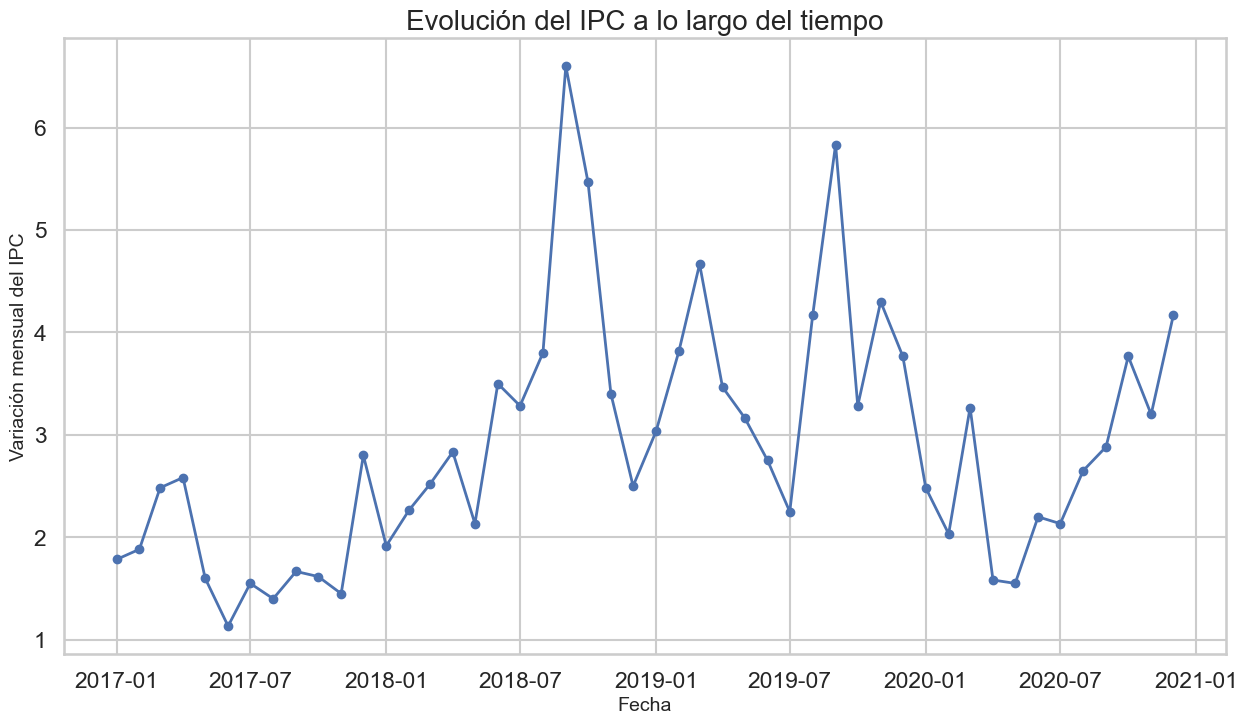

In [10]:
# Convertir 'periodo' a datetime
INDEC_filtered_Gral['periodo'] = pd.to_datetime(INDEC_filtered_Gral['periodo'], format='%Y%m')

# Crear el gráfico
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Graficar la línea
plt.plot(INDEC_filtered_Gral['periodo'], INDEC_filtered_Gral['v_m_IPC'], marker='o', linestyle='-', linewidth=2, markersize=6)

# Personalizar el gráfico
plt.title('Evolución del IPC a lo largo del tiempo', fontsize=20)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Variación mensual del IPC', fontsize=14)

# Formatear el eje x para mostrar las fechas de manera legible
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # Rotar y alinear las etiquetas de fecha

# Añadir una línea horizontal en y=0 para referencia
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)

# Añadir etiquetas para los valores máximos y mínimos
max_ipc = INDEC_filtered_Gral['v_m_IPC'].max()
min_ipc = INDEC_filtered_Gral['v_m_IPC'].min()
max_date = INDEC_filtered_Gral.loc[INDEC_filtered_Gral['v_m_IPC'] == max_ipc, 'Periodo'].iloc[0]
min_date = INDEC_filtered_Gral.loc[INDEC_filtered_Gral['v_m_IPC'] == min_ipc, 'Periodo'].iloc[0]

plt.annotate(f'Máximo: {max_ipc:.2f}', xy=(max_date, max_ipc), xytext=(10, 10),
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.annotate(f'Mínimo: {min_ipc:.2f}', xy=(min_date, min_ipc), xytext=(10, -10),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# random forest

### AGREGADO POR PORDUCT_ID

In [11]:
#Agregamos variables exogenas
df_combined = pd.merge(
    data,
    INDEC_filtered_Gral[['periodo', 'v_m_IPC']],
    on='periodo',
    how='left'
)







#save it 
data=df_combined

In [ ]:
# Importaciones necesarias
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the product IDs to predict
products_to_predict = pd.read_csv('../datasets/product_id_apredecir201912.txt')

# Aseguramos que periodo sea datetime
data['periodo'] = pd.to_datetime(data['periodo'])


# 2. Selección de características relevantes basadas en el nuevo FE
relevant_features = [
    'product_id', 
    'periodo', 
    'tn', 
    'stock_final',
    # Características temporales
    'year', 
    'month',
    'quarter', 
    'day_of_week',
      'is_weekend',
    'is_month_start',
      'is_month_end',
    
    # Lags y rolling features
    'sales_lag_1', 
    'sales_lag_2', 
    'sales_lag_3',
    'sales_rolling_mean_3',
    'sales_rolling_mean_6',
    'sales_rolling_std_3',
    'sales_ewma_3', 
    'sales_ewma_6',
    
    # Características de producto y cliente
    'product_id_mean', 
    'product_id_std', 
    'customer_id_mean',
    'brand_mean', 
    'cat1_mean', 
    'cat2_mean',
      'cat3_mean',
    
    # Características de estacionalidad
    'sin_month',
      'cos_month',
    
    # Features relativos y de stock
    'sales_relative_to_product_mean',
    'stock_turnover', 
    'days_of_stock',
    
    # Características categóricas
    'cat1',
      'cat2',
      'cat3', 
      'brand', 
      'sku_size',
    
    # Diferencias y variaciones
    'sales_diff',
    'sales_pct_change', 
      'yoy_growth',
    
    # Frecuencia y antigüedad
    'purchase_frequency', 
    'days_since_first_purchase',
      'days_since_last_purchase',
    
    # Ciclo de vida del producto
    'product_age_months',
     'product_lifecycle_stage',
     'is_new_product',
    
    # Features de familia
    'family_total_sales', 
    'product_vs_family_sales',
    'family_sales_trend',
    
    # Lealtad del cliente
    'customer_tenure',

    #variables exogenas 
    'v_m_IPC'
]

# 3. Filtrar y agrupar datos
data_filtered = data[relevant_features]

# Definir diccionario de agregación
agg_dict = {col: 'mean' for col in data_filtered.columns if col not in ['product_id', 'periodo']}
agg_dict.update({
    'tn': 'sum',
    'cat1': 'first',
    'cat2': 'first',
    'cat3': 'first',
    'brand': 'first',
    'sku_size': 'first',
    'product_lifecycle_stage': 'last'
})

data_grouped = data_filtered.groupby(['product_id', 'periodo']).agg(agg_dict).reset_index()

# 4. Filtrar solo productos a predecir y ordenar
data_grouped = data_grouped[data_grouped['product_id'].isin(products_to_predict['product_id'])]
data_grouped = data_grouped.sort_values(['product_id', 'periodo'])

# 5. Calcular promedios globales para fallback
global_avg_sales = data_grouped['tn'].mean()
global_avg_by_cat1 = data_grouped.groupby('cat1')['tn'].mean()
global_avg_by_cat2 = data_grouped.groupby('cat2')['tn'].mean()
global_avg_by_brand = data_grouped.groupby('brand')['tn'].mean()

In [97]:
data_grouped.head()

,product_id,periodo,tn,stock_final,year,month,quarter,day_of_week,is_weekend,is_month_start,is_month_end,sales_lag_1,sales_lag_2,sales_lag_3,sales_rolling_mean_3,sales_rolling_mean_6,sales_rolling_std_3,sales_ewma_3,sales_ewma_6,product_id_mean,product_id_std,customer_id_mean,brand_mean,cat1_mean,cat2_mean,cat3_mean,sin_month,cos_month,sales_relative_to_product_mean,stock_turnover,days_of_stock,cat1,cat2,cat3,brand,sku_size,sales_diff,sales_pct_change,yoy_growth,purchase_frequency,days_since_first_purchase,days_since_last_purchase,product_age_months,product_lifecycle_stage,is_new_product,family_total_sales,product_vs_family_sales,family_sales_trend,customer_tenure,v_m_IPC
0,20001,2017-01-01,934.77222,0.0,2017.0,1.0,1.0,6.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,5.025657,5.025657,4.216114,23.206451,0.295294,0.842301,0.515697,0.830332,0.692172,0.500000,8.660254e-01,1.192012,0.0,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,0.000000,0.000000,0.0,0.630249,0.000000,962.161290,0.0,Nuevo,1.0,21686.66308,0.000232,0.000000,1006.290323,1.783333
1,20001,2017-02-01,798.01620,0.0,2017.0,2.0,1.0,2.0,0.0,1.0,0.0,3.693336,0.000000,0.000000,0.000000,0.0,0.000000,3.398086,3.459054,4.216114,23.206451,0.244900,0.842301,0.515697,0.830332,0.692172,0.866025,5.000000e-01,0.748133,0.0,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,-0.731615,0.006377,0.0,0.565751,22.055336,949.573123,1.0,Nuevo,1.0,21633.83584,0.000146,-0.208803,1030.090909,1.883333
2,20001,2017-03-01,1303.35771,0.0,2017.0,3.0,1.0,2.0,0.0,1.0,0.0,2.677756,3.135618,0.000000,3.264663,0.0,2.030556,3.761934,3.616517,4.216114,23.206451,0.221241,0.842301,0.515697,0.830332,0.692172,1.000000,6.123234e-17,1.037373,0.0,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,1.635906,0.142581,0.0,0.539433,42.402685,906.080537,2.0,Nuevo,1.0,31003.50944,0.000141,31.441858,1026.023490,2.483333
3,20001,2017-04-01,1069.96130,0.0,2017.0,4.0,2.0,5.0,1.0,1.0,0.0,4.301141,2.633200,3.083136,3.462861,0.0,2.311311,3.607320,3.542719,4.216114,23.206451,0.219854,0.842301,0.515697,0.830332,0.692172,0.866025,-5.000000e-01,0.837554,0.0,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,-0.777156,-0.278745,0.0,0.534505,71.894389,876.412541,3.0,Crecimiento,0.0,26337.52384,0.000134,-15.399292,1026.356436,2.583333
4,20001,2017-05-01,1502.20132,0.0,2017.0,5.0,2.0,0.0,0.0,1.0,0.0,3.213097,3.913651,2.395974,3.868509,0.0,2.051754,3.929729,3.693660,4.216114,23.206451,0.202922,0.842301,0.515697,0.830332,0.692172,0.500000,-8.660254e-01,1.069970,0.0,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,1.272641,0.587180,0.0,0.521139,92.714715,848.345345,4.0,Crecimiento,0.0,31649.88029,0.000143,15.953022,1028.474474,1.600000


100%|██████████| 780/780 [00:55<00:00, 14.14it/s]
C:\Users\s1093678\AppData\Local\Temp\ipykernel_14672\962709357.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_importances.head(20).values,


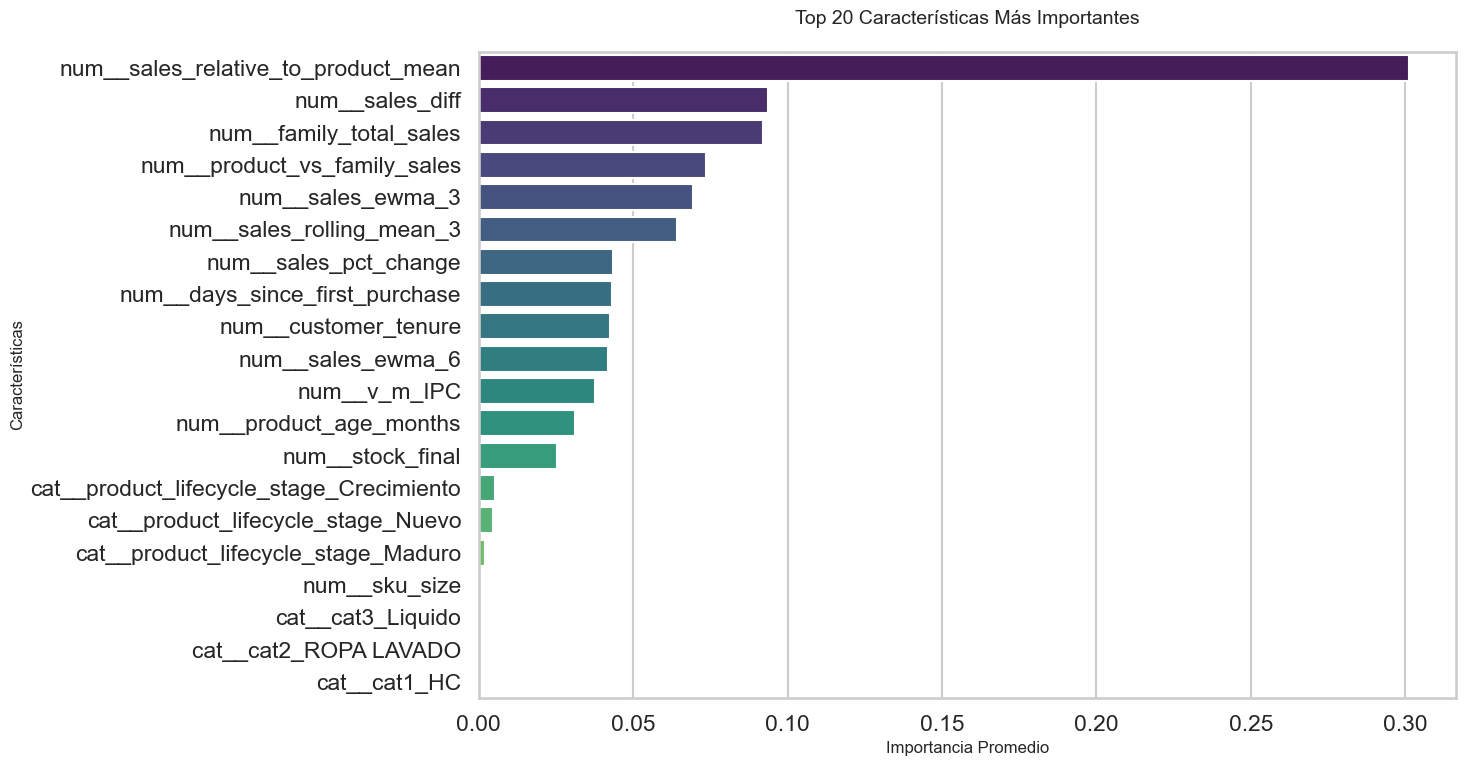


Importancia de características (top 20):
num__sales_relative_to_product_mean: 0.3014
num__sales_diff: 0.0938
num__family_total_sales: 0.0921
num__product_vs_family_sales: 0.0736
num__sales_ewma_3: 0.0694
num__sales_rolling_mean_3: 0.0642
num__sales_pct_change: 0.0433
num__days_since_first_purchase: 0.0431
num__customer_tenure: 0.0425
num__sales_ewma_6: 0.0417
num__v_m_IPC: 0.0376
num__product_age_months: 0.0313
num__stock_final: 0.0252
cat__product_lifecycle_stage_Crecimiento: 0.0053
cat__product_lifecycle_stage_Nuevo: 0.0045
cat__product_lifecycle_stage_Maduro: 0.0021
num__sku_size: 0.0000
cat__cat3_Liquido: 0.0000
cat__cat2_ROPA LAVADO: 0.0000
cat__cat1_HC: 0.0000


In [107]:
def prepare_features(group):
    group = group.copy()
    
    categorical_features = ['cat1', 'cat2', 'cat3', 'brand', 'product_lifecycle_stage']
    
    numerical_features = [col for col in group.columns 
                         if col not in ['product_id', 'periodo', 'tn'] + categorical_features]
    
    features = group[categorical_features + numerical_features]
    target = group['tn']
    return features, target

def random_forest_forecast(group):
    if len(group) < 6:
        # Estrategia de fallback para datos insuficientes
        last_row = group.iloc[-1]
        cat1_avg = global_avg_by_cat1.get(last_row['cat1'], global_avg_sales)
        cat2_avg = global_avg_by_cat2.get(last_row['cat2'], global_avg_sales)
        brand_avg = global_avg_by_brand.get(last_row['brand'], global_avg_sales)
        return np.mean([cat1_avg, cat2_avg, brand_avg]), None

    features, target = prepare_features(group)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), features.select_dtypes(include=['int64', 'float64']).columns),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), features.select_dtypes(include=['object', 'category']).columns)
        ])

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ))
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Prepare features for February 2020
    last_row = group.iloc[-1]
    next_date = pd.Timestamp('2020-02-01')
    
    next_features = last_row[features.columns].to_dict()
    next_features.update({
        'year': 2020,
        'month': 2,
        'quarter': 1,
        'days_since_first_purchase': last_row['days_since_first_purchase'] + 60,
        'days_since_last_purchase': 60,
        'product_age_months': last_row['product_age_months'] + 2
    })
    
    next_features = pd.DataFrame([next_features])
    
    # Make prediction
    prediction = model.predict(next_features)
    
    # Get feature importances
    feature_importances = model.named_steps['regressor'].feature_importances_
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    importances = dict(zip(feature_names, feature_importances))
    
    return prediction[0], importances

# Main prediction loop
predictions = []
errors = []
all_importances = []

for product_id in tqdm(products_to_predict['product_id'], total=len(products_to_predict)):
    group = data_grouped[data_grouped['product_id'] == product_id]
    try:
        pred, importances = random_forest_forecast(group)
        predictions.append({'product_id': product_id, 'tn': pred})
        if importances is not None:
            all_importances.append(importances)
    except Exception as e:
        errors.append(product_id)
        print(f"Error for product {product_id}: {str(e)}")

predictions_df = pd.DataFrame(predictions)

import matplotlib.pyplot as plt
import seaborn as sns

# Después de completar las predicciones
if all_importances:
    # Convertir la lista de diccionarios a DataFrame
    importances_df = pd.DataFrame(all_importances)
    
    # Calcular el promedio de importancia para cada característica
    avg_importances = importances_df.mean().sort_values(ascending=False)
    
    # Crear la figura
    plt.figure(figsize=(15, 8))
    
    # Crear el gráfico de barras para las top 20 características
    sns.barplot(x=avg_importances.head(20).values, 
                y=avg_importances.head(20).index,
                palette='viridis')
    
    # Personalizar el gráfico
    plt.title('Top 20 Características Más Importantes', fontsize=14, pad=20)
    plt.xlabel('Importancia Promedio', fontsize=12)
    plt.ylabel('Características', fontsize=12)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()
    
    # Imprimir los valores numéricos
    print("\nImportancia de características (top 20):")
    for feat, imp in avg_importances.head(20).items():
        print(f"{feat}: {imp:.4f}")
    
    # Opcionalmente, guardar las importancias en un archivo CSV
    avg_importances.to_csv('feature_importances_202002.csv')

# Guardar predicciones
predictions_df.to_csv('predictions_202002.csv', index=False)

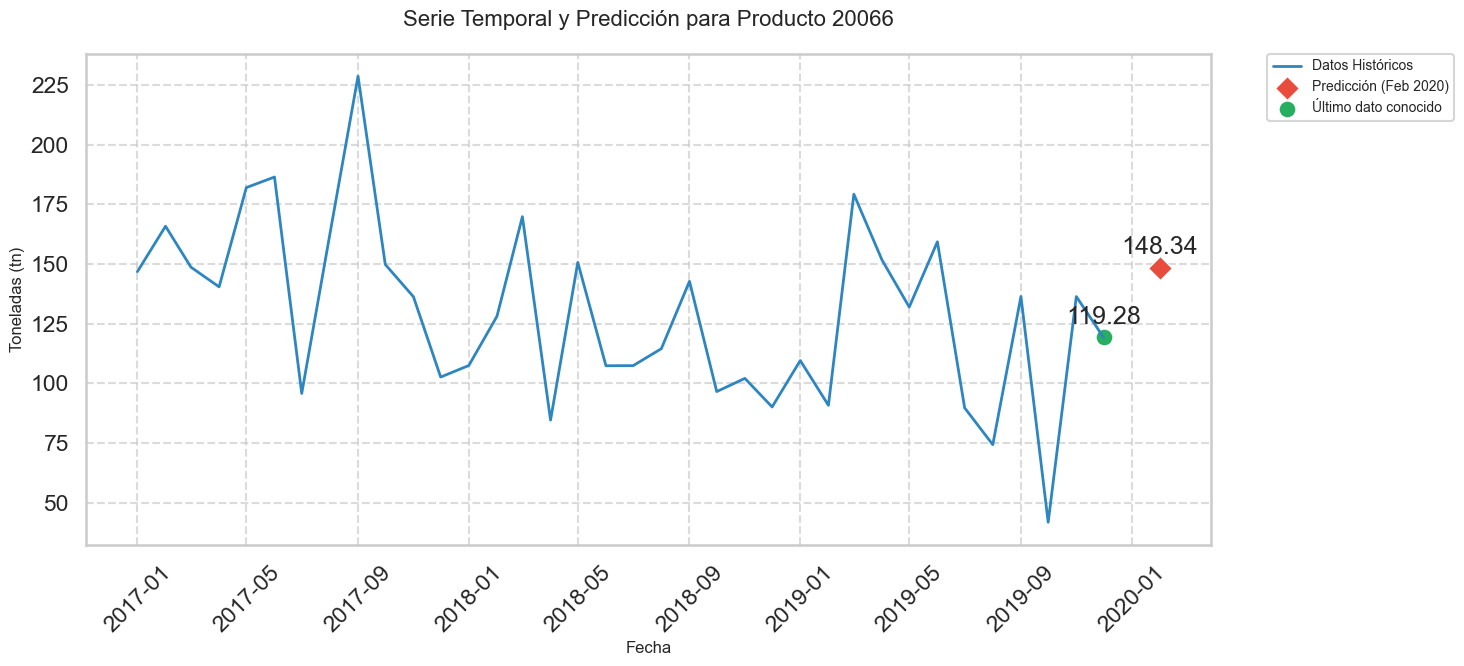


Estadísticas para Producto 20066:
Último valor conocido: 119.28
Predicción para Feb 2020: 148.34
Diferencia: 29.06

Resumen de datos:
count     36.00000
mean     129.70484
std       37.40084
min       41.86287
25%      102.54316
50%      134.17620
75%      150.96683
max      228.72598
Name: tn, dtype: float64

Primeros 5 registros:
     periodo         tn
0 2017-01-01  146.83470
1 2017-02-01  165.86167
2 2017-03-01  148.72163
3 2017-04-01  140.45743
4 2017-05-01  182.05823

Últimos 5 registros:
      periodo         tn
31 2019-08-01   74.36077
32 2019-09-01  136.43883
33 2019-10-01   41.86287
34 2019-11-01  136.40388
35 2019-12-01  119.28134


: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_product_forecast(sales_data, predictions_df, product_id):
    # Filter data for specific product
    product_data = sales_data[sales_data['product_id'] == product_id].copy()
    
    # Convert 'periodo' to datetime and set as index
    product_data['periodo'] = pd.to_datetime(product_data['periodo'], format='%Y%m')
    
    # Group by periodo and sum the 'tn' column
    product_data = product_data.groupby('periodo')['tn'].sum().reset_index()
    
    # Sort data by date
    product_data = product_data.sort_values('periodo')
    
    # Get the forecast for this product
    product_forecast = predictions_df[predictions_df['product_id'] == product_id].iloc[0]

    # Create forecast point
    forecast_data = pd.DataFrame({
        'periodo': [pd.to_datetime('2020-02-01')],
        'tn': [product_forecast['tn']]
    })

    # Create the plot
    plt.figure(figsize=(15, 7))
   
    # Set style
    sns.set_style("whitegrid")
   
    # Plot historical data with a thicker line
    sns.lineplot(x='periodo', y='tn', data=product_data,
                label='Datos Históricos',
                linewidth=2,
                color='#2E86C1')

    # Plot forecast point with a larger marker
    sns.scatterplot(x='periodo', y='tn', data=forecast_data,
                    label='Predicción (Feb 2020)',
                    color='#E74C3C',
                    s=150,  # Larger marker size
                    marker='D')  # Diamond marker

    # Add last known point with different color
    last_known = product_data.iloc[-1:]
    sns.scatterplot(x='periodo', y='tn', data=last_known,
                    label='Último dato conocido',
                    color='#27AE60',
                    s=150,
                    marker='o')

    # Customize the plot
    plt.title(f'Serie Temporal y Predicción para Producto {product_id}',
              fontsize=16,
              pad=20)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Toneladas (tn)', fontsize=12)
   
    # Format axis
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
   
    # Add value labels for the last known point and prediction
    plt.annotate(f'{last_known.tn.values[0]:.2f}',
                (last_known.periodo.values[0], last_known.tn.values[0]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
   
    plt.annotate(f'{product_forecast.tn:.2f}',
                (forecast_data.periodo.values[0], forecast_data.tn.values[0]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

    # Adjust legend
    plt.legend(bbox_to_anchor=(1.05, 1),
              loc='upper left',
              borderaxespad=0.,
              fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"\nEstadísticas para Producto {product_id}:")
    print(f"Último valor conocido: {last_known.tn.values[0]:.2f}")
    print(f"Predicción para Feb 2020: {product_forecast.tn:.2f}")
    print(f"Diferencia: {product_forecast.tn - last_known.tn.values[0]:.2f}")

    # Print data summary for debugging
    print("\nResumen de datos:")
    print(product_data['tn'].describe())
    print("\nPrimeros 5 registros:")
    print(product_data.head())
    print("\nÚltimos 5 registros:")
    print(product_data.tail())

# Load the sales data
sales = pd.read_csv("../datasets/sell-in.txt", sep="\t", dtype={"periodo": str})


# Use the function
plot_product_forecast(sales, predictions_df, 20066)

### AGREGADO POR PORDUCT_ID Y CUSTOMER_ID

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Función para optimizar los tipos de datos
def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

# Load the product IDs to predict
products_to_predict = pd.read_csv('../datasets/product_id_apredecir201912.txt')

# Aseguramos que periodo sea datetime
data['periodo'] = pd.to_datetime(data['periodo'])

# Normalize the target variable
scaler = MinMaxScaler()
data['tn_normalized'] = scaler.fit_transform(data[['tn']])

# Optimizar los tipos de datos del DataFrame original
data = optimize_dtypes(data)

# 2. Selección de características relevantes basadas en el nuevo FE
relevant_features = [
    'product_id',
    'periodo',
    'tn',
    'tn_normalized',
    'customer_id',
    'stock_final',
    # Características temporales
    'year',
    'month',
    'quarter',
    'day_of_week',
    'is_weekend',
    'is_month_start',
    'is_month_end',
    
    # Lags y rolling features
    'sales_lag_1',
    'sales_lag_2',
    'sales_lag_3',
    'sales_rolling_mean_3',
    'sales_rolling_mean_6',
    'sales_rolling_std_3',
    
    # Características de producto y cliente
    'product_id_mean',
    'product_id_std',
    'customer_id_mean',
    'brand_mean',
    'cat1_mean',
    'cat2_mean',
    'cat3_mean',
    
    # Características de estacionalidad
    'sin_month',
    'cos_month',
    
    # Features relativos y de stock
    'sales_relative_to_product_mean',
    'stock_turnover',
    'days_of_stock',
    
    # Características categóricas
    'cat1',
    'cat2',
    'cat3',
    'brand',
    'sku_size',
    
    # Diferencias y variaciones
    'sales_diff',
    'sales_pct_change',
    'yoy_growth',
    
    # Frecuencia y antigüedad
    'purchase_frequency',
    'days_since_first_purchase',
    'days_since_last_purchase',
    
    # Ciclo de vida del producto
    'product_age_months',
    'product_lifecycle_stage',
    'is_new_product',
    
    # Features de familia
    'family_total_sales',
    'product_vs_family_sales',
    'family_sales_trend',
    
    # Lealtad del cliente
    'customer_tenure',

    #variables exogenas
    'v_m_IPC'
]

# 3. Filtrar y agrupar datos
data_filtered = data[relevant_features]

# Optimizar los tipos de datos nuevamente después de filtrar
data_filtered = optimize_dtypes(data_filtered)

# Definir diccionario de agregación
agg_dict = {col: 'mean' for col in data_filtered.columns if col not in ['product_id', 'customer_id', 'periodo']}
agg_dict.update({
    'tn': 'sum',
    'tn_normalized': 'sum',
    'cat1': 'first',
    'cat2': 'first',
    'cat3': 'first',
    'brand': 'first',
    'sku_size': 'first',
    'product_lifecycle_stage': 'last'
})

# Intentar la agrupación
try:
    data_grouped = data_filtered.groupby(['product_id', 'customer_id', 'periodo']).agg(agg_dict).reset_index()
    
    # 4. Filtrar solo productos a predecir y ordenar
    data_grouped = data_grouped[data_grouped['product_id'].isin(products_to_predict['product_id'])]
    data_grouped = data_grouped.sort_values(['product_id', 'periodo'])
    
    # 5. Calcular promedios globales para fallback
    global_avg_sales = data_grouped['tn'].mean()
    global_avg_by_cat1 = data_grouped.groupby('cat1')['tn'].mean()
    global_avg_by_cat2 = data_grouped.groupby('cat2')['tn'].mean()
    global_avg_by_brand = data_grouped.groupby('brand')['tn'].mean()
    
    print("Procesamiento completado con éxito.")
except MemoryError:
    print("Todavía hay problemas de memoria. Considerando implementar procesamiento por lotes.")
    # Aquí puedes implementar la lógica de procesamiento por lotes si es necesario

# Imprimir información sobre el uso de memoria
print(data_filtered.info(memory_usage='deep'))

Procesamiento completado con éxito.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6585163 entries, 0 to 6585162
Data columns (total 50 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   product_id                      int32         
 1   periodo                         datetime64[ns]
 2   tn                              float32       
 3   tn_normalized                   float32       
 4   customer_id                     int32         
 5   stock_final                     float32       
 6   year                            int32         
 7   month                           int32         
 8   quarter                         int32         
 9   day_of_week                     int32         
 10  is_weekend                      int32         
 11  is_month_start                  int32         
 12  is_month_end                    int32         
 13  sales_lag_1                     float32       
 14  sales_lag_2   

100%|██████████| 780/780 [42:18<00:00,  3.25s/it]  
C:\Users\s1093678\AppData\Local\Temp\ipykernel_32836\3206473494.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_importances.head(20).values,


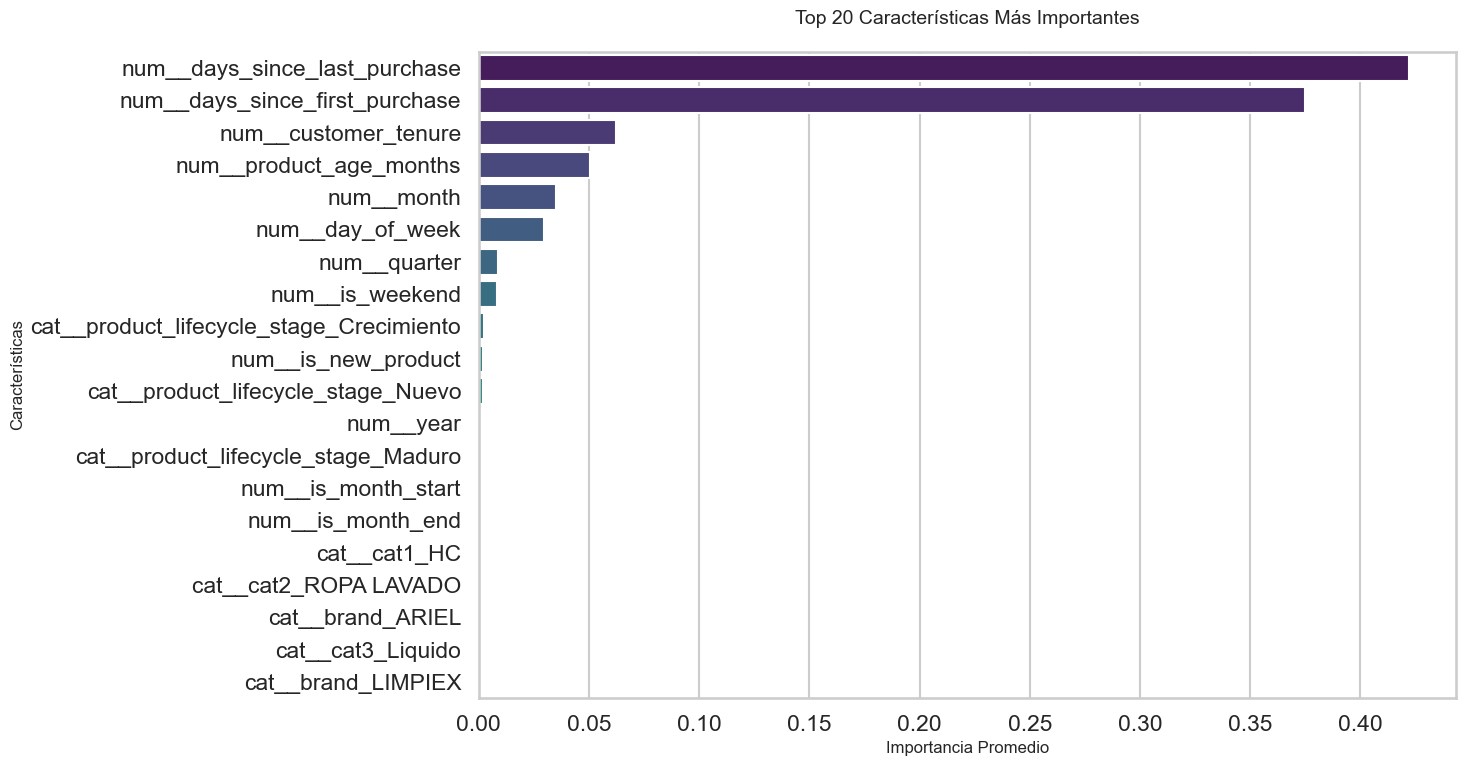


Importancia de características (top 20):
num__days_since_last_purchase: 0.4223
num__days_since_first_purchase: 0.3750
num__customer_tenure: 0.0621
num__product_age_months: 0.0506
num__month: 0.0353
num__day_of_week: 0.0297
num__quarter: 0.0087
num__is_weekend: 0.0083
cat__product_lifecycle_stage_Crecimiento: 0.0024
num__is_new_product: 0.0020
cat__product_lifecycle_stage_Nuevo: 0.0019
num__year: 0.0011
cat__product_lifecycle_stage_Maduro: 0.0010
num__is_month_start: 0.0000
num__is_month_end: 0.0000
cat__cat1_HC: 0.0000
cat__cat2_ROPA LAVADO: 0.0000
cat__brand_ARIEL: 0.0000
cat__cat3_Liquido: 0.0000
cat__brand_LIMPIEX: 0.0000


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tqdm import tqdm

def prepare_features(group):
    group = group.copy()
    
    categorical_features = ['cat1', 'cat2', 'cat3', 'brand', 'product_lifecycle_stage']
    
    numerical_features = [col for col in group.columns
                         if col not in ['product_id', 'periodo', 'tn', 'tn_normalized'] + categorical_features]
    
    features = group[categorical_features + numerical_features]
    target = group['tn_normalized']
    return features, target

def random_forest_forecast(group):
    if len(group) < 6:
        # Estrategia de fallback para datos insuficientes
        last_row = group.iloc[-1]
        cat1_avg = global_avg_by_cat1.get(last_row['cat1'], global_avg_sales)
        cat2_avg = global_avg_by_cat2.get(last_row['cat2'], global_avg_sales)
        brand_avg = global_avg_by_brand.get(last_row['brand'], global_avg_sales)
        return np.mean([cat1_avg, cat2_avg, brand_avg]), None

    features, target = prepare_features(group)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), features.select_dtypes(include=['int64', 'float64']).columns),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), features.select_dtypes(include=['object', 'category']).columns)
        ])

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ))
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    # Train model
    model.fit(X_train, y_train)

    # Prepare features for February 2020
    next_date = pd.Timestamp('2020-02-01')
    
    customer_predictions = []
    for customer_id, customer_group in group.groupby('customer_id'):
        last_row = customer_group.iloc[-1]
        
        next_features = last_row[features.columns].to_dict()
        next_features.update({
            'year': 2020,
            'month': 2,
            'quarter': 1,
            'days_since_first_purchase': last_row['days_since_first_purchase'] + 60,
            'days_since_last_purchase': 60,
            'product_age_months': last_row['product_age_months'] + 2
        })
    
        next_features = pd.DataFrame([next_features])
    
        # Make prediction
        prediction = model.predict(next_features)
        customer_predictions.append(prediction[0])

    # Get feature importances
    feature_importances = model.named_steps['regressor'].feature_importances_
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    importances = dict(zip(feature_names, feature_importances))
    
    # Sum customer predictions
    total_prediction = np.sum(customer_predictions)

    # Denormalize the prediction
    total_prediction = scaler.inverse_transform([[total_prediction]])[0][0]

    return total_prediction, importances

def sanity_check(prediction, historical_data):
    max_historical = historical_data.max()
    min_historical = historical_data.min()
    if prediction > 2 * max_historical:
        return max_historical * 1.5
    elif prediction < 0.5 * min_historical:
        return min_historical * 0.75
    return prediction

# Main prediction loop
predictions = []
errors = []
all_importances = []

for product_id in tqdm(products_to_predict['product_id'], total=len(products_to_predict)):
    group = data_grouped[data_grouped['product_id'] == product_id]
    try:
        pred, importances = random_forest_forecast(group)
        pred = sanity_check(pred, group['tn'])
        predictions.append({'product_id': product_id, 'tn': pred})
        if importances is not None:
            all_importances.append(importances)
    except Exception as e:
        errors.append(product_id)
        print(f"Error for product {product_id}: {str(e)}")

predictions_df = pd.DataFrame(predictions)

import matplotlib.pyplot as plt
import seaborn as sns

# Después de completar las predicciones
if all_importances:
    # Convertir la lista de diccionarios a DataFrame
    importances_df = pd.DataFrame(all_importances)
    
    # Calcular el promedio de importancia para cada característica
    avg_importances = importances_df.mean().sort_values(ascending=False)
    
    # Crear la figura
    plt.figure(figsize=(15, 8))
    
    # Crear el gráfico de barras para las top 20 características
    sns.barplot(x=avg_importances.head(20).values,
                y=avg_importances.head(20).index,
                palette='viridis')
    
    # Personalizar el gráfico
    plt.title('Top 20 Características Más Importantes', fontsize=14, pad=20)
    plt.xlabel('Importancia Promedio', fontsize=12)
    plt.ylabel('Características', fontsize=12)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()
    
    # Imprimir los valores numéricos
    print("\nImportancia de características (top 20):")
    for feat, imp in avg_importances.head(20).items():
        print(f"{feat}: {imp:.4f}")
    
    # Opcionalmente, guardar las importancias en un archivo CSV
    avg_importances.to_csv('feature_importances_202002.csv')

# Guardar predicciones
predictions_df.to_csv('predictions_202002.csv', index=False)

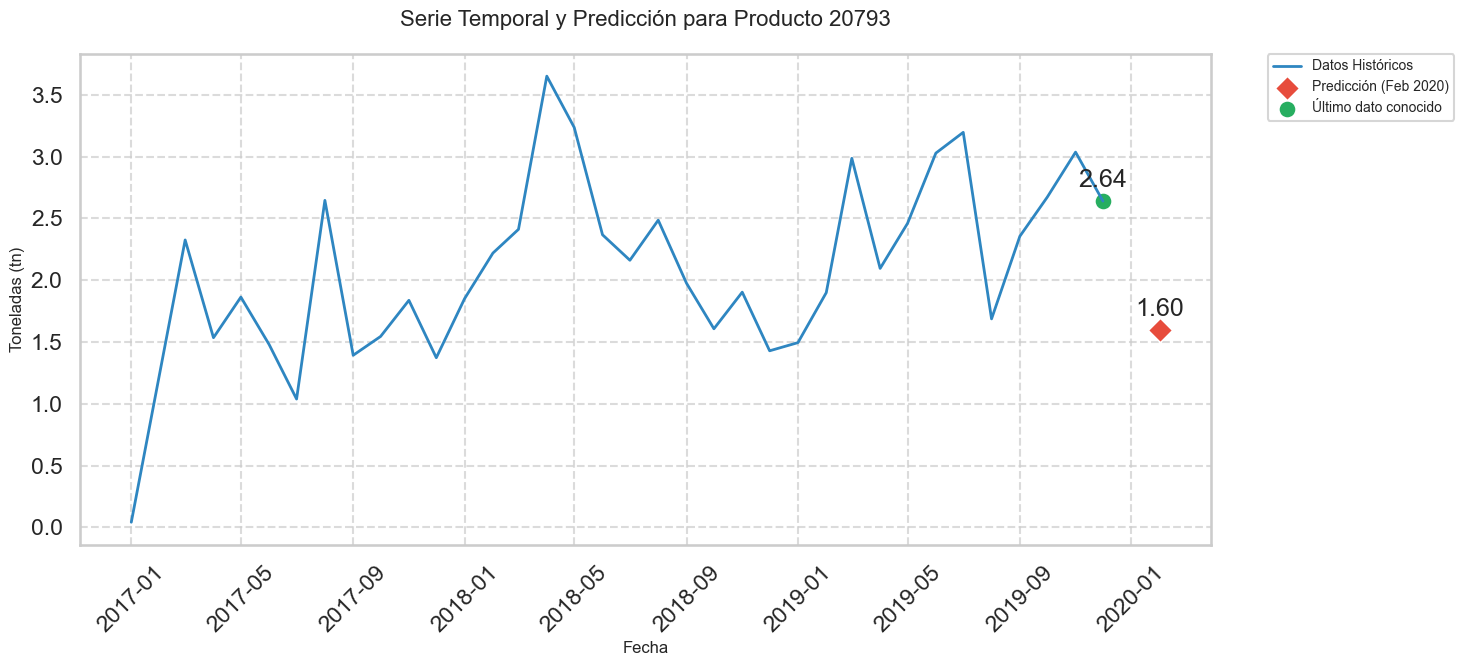


Estadísticas para Producto 20793:
Último valor conocido: 2.64
Predicción para Feb 2020: 1.60
Diferencia: -1.04

Resumen de datos:
count    35.000000
mean      2.112827
std       0.724297
min       0.042040
25%       1.576545
50%       2.096080
75%       2.563525
max       3.651640
Name: tn, dtype: float64

Primeros 5 registros:
     periodo       tn
0 2017-01-01  0.04204
1 2017-03-01  2.32632
2 2017-04-01  1.53550
3 2017-05-01  1.86386
4 2017-06-01  1.47947

Últimos 5 registros:
      periodo       tn
30 2019-08-01  1.68766
31 2019-09-01  2.35628
32 2019-10-01  2.67266
33 2019-11-01  3.03699
34 2019-12-01  2.64061


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_product_forecast(sales_data, predictions_df, product_id):
    # Filter data for specific product
    product_data = sales_data[sales_data['product_id'] == product_id].copy()
    
    # Convert 'periodo' to datetime and set as index
    product_data['periodo'] = pd.to_datetime(product_data['periodo'], format='%Y%m')
    
    # Group by periodo and sum the 'tn' column
    product_data = product_data.groupby('periodo')['tn'].sum().reset_index()
    
    # Sort data by date
    product_data = product_data.sort_values('periodo')
    
    # Get the forecast for this product
    product_forecast = predictions_df[predictions_df['product_id'] == product_id].iloc[0]

    # Create forecast point
    forecast_data = pd.DataFrame({
        'periodo': [pd.to_datetime('2020-02-01')],
        'tn': [product_forecast['tn']]
    })

    # Create the plot
    plt.figure(figsize=(15, 7))
   
    # Set style
    sns.set_style("whitegrid")
   
    # Plot historical data with a thicker line
    sns.lineplot(x='periodo', y='tn', data=product_data,
                label='Datos Históricos',
                linewidth=2,
                color='#2E86C1')

    # Plot forecast point with a larger marker
    sns.scatterplot(x='periodo', y='tn', data=forecast_data,
                    label='Predicción (Feb 2020)',
                    color='#E74C3C',
                    s=150,  # Larger marker size
                    marker='D')  # Diamond marker

    # Add last known point with different color
    last_known = product_data.iloc[-1:]
    sns.scatterplot(x='periodo', y='tn', data=last_known,
                    label='Último dato conocido',
                    color='#27AE60',
                    s=150,
                    marker='o')

    # Customize the plot
    plt.title(f'Serie Temporal y Predicción para Producto {product_id}',
              fontsize=16,
              pad=20)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Toneladas (tn)', fontsize=12)
   
    # Format axis
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
   
    # Add value labels for the last known point and prediction
    plt.annotate(f'{last_known.tn.values[0]:.2f}',
                (last_known.periodo.values[0], last_known.tn.values[0]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
   
    plt.annotate(f'{product_forecast.tn:.2f}',
                (forecast_data.periodo.values[0], forecast_data.tn.values[0]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

    # Adjust legend
    plt.legend(bbox_to_anchor=(1.05, 1),
              loc='upper left',
              borderaxespad=0.,
              fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"\nEstadísticas para Producto {product_id}:")
    print(f"Último valor conocido: {last_known.tn.values[0]:.2f}")
    print(f"Predicción para Feb 2020: {product_forecast.tn:.2f}")
    print(f"Diferencia: {product_forecast.tn - last_known.tn.values[0]:.2f}")

    # Print data summary for debugging
    print("\nResumen de datos:")
    print(product_data['tn'].describe())
    print("\nPrimeros 5 registros:")
    print(product_data.head())
    print("\nÚltimos 5 registros:")
    print(product_data.tail())

# Load the sales data
sales = pd.read_csv("../datasets/sell-in.txt", sep="\t", dtype={"periodo": str})


# Use the function
plot_product_forecast(sales, predictions_df, 20793)

# SARIMA

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the data

products_to_predict = pd.read_csv('../datasets/product_id_apredecir201912.txt')

# Convert periodo to datetime
data['periodo'] = pd.to_datetime(data['periodo'])

# Filter for products that have been alive for more than 3 months and haven't been discontinued
product_lifespans = data.groupby('product_id')['periodo'].agg(['min', 'max'])
active_products = product_lifespans[
    (product_lifespans['max'] - product_lifespans['min'] > pd.Timedelta(days=90)) &
    (product_lifespans['max'] == data['periodo'].max())
].index

data = data[data['product_id'].isin(active_products)]

# Ensure we have the top 780 products
top_780_products = data.groupby('product_id')['tn'].sum().nlargest(780).index
data = data[data['product_id'].isin(top_780_products)]

# Aggregate data to monthly level
data_monthly = data.groupby(['periodo', 'product_id']).agg({
    'tn': 'sum',
    'stock_final': 'mean',
    'cat1': 'first',
    'cat2': 'first',
    'cat3': 'first',
    'brand': 'first',
    'sku_size': 'first',
    'cat1_avg_sales': 'mean',
    'cat2_avg_sales': 'mean',
    'cat3_avg_sales': 'mean',
    'brand_avg_sales': 'mean',
    'size_avg_sales': 'mean',
    'purchase_frequency': 'mean',
    'days_since_first_purchase': 'max',
    'days_since_last_purchase': 'min'
}).reset_index()

# Sort the data
data_monthly = data_monthly.sort_values(['product_id', 'periodo'])

c:\Users\s1093678\AppData\Local\miniconda3\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
def forecast_product(group, forecast_date):
    # Prepare time series data
    ts_data = group.set_index('periodo')['tn']
    
    try:
        # Try SARIMA first
        model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        results = model.fit(disp=False)
        forecast = results.forecast(steps=2)[-1]  # Get the second month forecast
    except:
        try:
            # If SARIMA fails, try Holt-Winters' Exponential Smoothing
            model = ExponentialSmoothing(ts_data, seasonal_periods=12, trend='add', seasonal='add')
            results = model.fit()
            forecast = results.forecast(2)[-1]
        except:
            # If both fail, use a simple moving average
            forecast = ts_data.rolling(window=3).mean().iloc[-1]
    
    return forecas

def safe_forecast(product_id, group, forecast_date):
    try:
        forecast = forecast_product(group, forecast_date)
        return {'product_id': product_id, 'tn': forecast}
    except Exception as e:
        error_msg = f"Error forecasting product {product_id}: {str(e)}"
        logging.error(error_msg)
        return {'product_id': product_id, 'error': str(e)}

# Main forecasting loop
forecast_date = pd.to_datetime('2020-03-01')
results = []

pbar = tqdm(products_to_predict['product_id'], total=len(products_to_predict))



  0%|          | 0/780 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(filename='forecast_errors.log', level=logging.ERROR,
                    format='%(asctime)s:%(levelname)s:%(message)s')

def forecast_product(group, start_date):
    # Prepare time series data
    ts_data = group.set_index('periodo')['tn']
    
    # Ensure we only use data up to the start_date
    ts_data = ts_data[ts_data.index <= start_date]
    
    if len(ts_data) < 3:
        # If less than 3 data points, use the mean of available data
        mean_value = ts_data.mean()
        return np.array([mean_value, mean_value])
    
    try:
        # Try SARIMA first
        model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        results = model.fit(disp=False)
        forecast = results.forecast(steps=2)
    except:
        try:
            # If SARIMA fails, try Holt-Winters' Exponential Smoothing
            model = ExponentialSmoothing(ts_data, seasonal_periods=12, trend='add', seasonal='add')
            results = model.fit()
            forecast = results.forecast(2)
        except:
            # If both fail, use a simple moving average
            forecast = pd.Series([ts_data.rolling(window=3).mean().iloc[-1]] * 2)
    
    # Return both forecasted values
    return forecast.values

def safe_forecast(product_id, group, start_date):
    try:
        forecast = forecast_product(group, start_date)
        return {
            'product_id': product_id, 
            'tn_202001': forecast[0],  # January 2020 forecast
            'tn_202002': forecast[1]   # February 2020 forecast
        }
    except Exception as e:
        error_msg = f"Error forecasting product {product_id}: {str(e)}"
        logging.error(error_msg)
        return {'product_id': product_id, 'tn_202001': np.nan, 'tn_202002': np.nan}

# Main forecasting loop
start_date = pd.to_datetime('2019-12-01')
results = []

pbar = tqdm(products_to_predict['product_id'], total=len(products_to_predict))

for product_id in pbar:
    group = data_monthly[data_monthly['product_id'] == product_id]
    result = safe_forecast(product_id, group, start_date)
    results.append(result)
    
    pbar.set_description(f"Processed: {len(results)}")

pbar.close()

# Create DataFrame with all predictions
predictions_df = pd.DataFrame(results)

print(f"Forecasting complete. {len(predictions_df)} predictions generated.")

# Save predictions
predictions_df.to_csv('predictions_202001_202002_all.csv', index=False)

print("All predictions saved to 'predictions_202001_202002_all.csv'")

In [ ]:
# Calculate average feature importances
avg_importances = pd.DataFrame(feature_importances).mean().sort_values(ascending=False)

print("Average Feature Importances:")
print(avg_importances)

# Visualize feature importances
plt.figure(figsize=(10, 6))
avg_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

NameError: name 'feature_importances' is not defined

In [ ]:
predictions_df.to_csv('predictions_202003.csv', index=False)
print(f"Predictions saved to 'predictions_202003.csv'")

In [ ]:
predictions_df.head

<bound method NDFrame.head of      product_id    tn_202001    tn_202002
0         20001  1191.492553  1163.428529
1         20002  1420.109239  1138.317221
2         20003   860.910795   605.600312
3         20004   447.825298   402.336726
4         20005   590.773427   617.236960
..          ...          ...          ...
775       21263          NaN          NaN
776       21265          NaN          NaN
777       21266          NaN          NaN
778       21267          NaN          NaN
779       21276          NaN          NaN

[780 rows x 3 columns]>

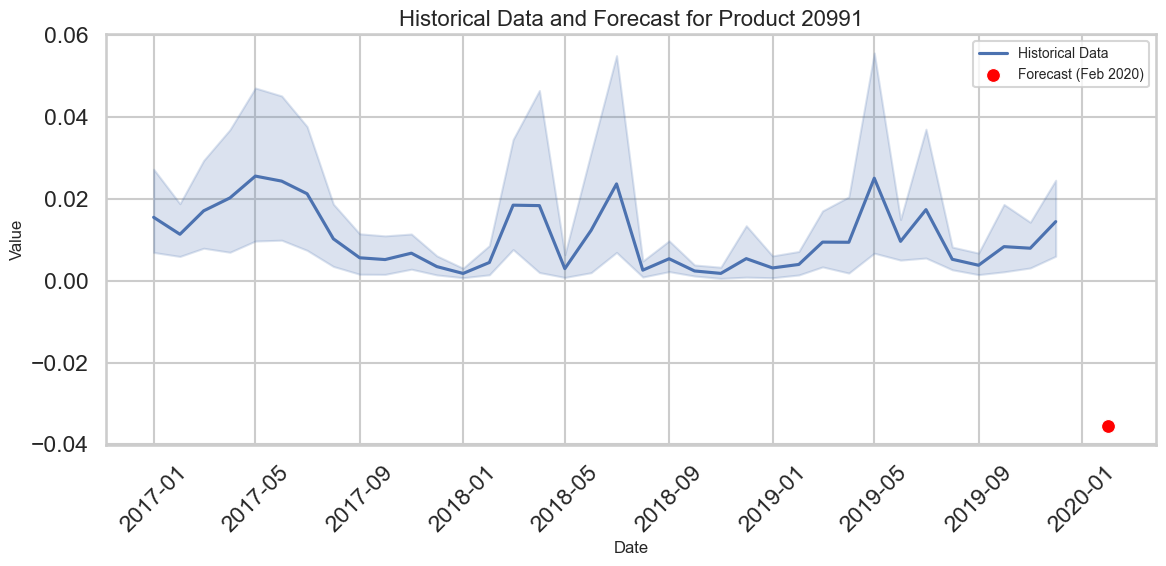

In [ ]:
# Load the data
data_monthly = data  # Assuming 'data' is your DataFrame
predictions = predictions_df

# Filter data for product 20991
product_data = data_monthly[data_monthly['product_id'] == 20991].copy()
product_forecast = predictions[predictions['product_id'] == 20991].iloc[0]

# Convert 'periodo' to datetime
product_data['periodo'] = pd.to_datetime(product_data['periodo'])

# Sort data by date
product_data = product_data.sort_values('periodo')

# Create a DataFrame for the forecast (only February 2020)
forecast_data = pd.DataFrame({
    'periodo': [pd.to_datetime('2020-02-01')],
    'tn_202002': [product_forecast['tn_202002']]  # Using 'tn' which represents tn_202002
})

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot historical data
sns.lineplot(x='periodo', y='tn', data=product_data, label='Historical Data')

# Plot forecast
sns.scatterplot(x='periodo', y='tn_202002', data=forecast_data, label='Forecast (Feb 2020)', color='red', s=100)

# Customize the plot
plt.title(f'Historical Data and Forecast for Product 20991', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# XGboost

In [ ]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
features_num= [col for col in numeric_columns if col != 'tn']
features_num

['product_id',
 'customer_id',
 'stock_final',
 'sku_size',
 'is_weekend',
 'is_month_start',
 'is_month_end',
 'sales_lag_1',
 'sales_lag_2',
 'sales_lag_3',
 'sales_lag_6',
 'sales_lag_12',
 'sales_rolling_mean_3',
 'sales_rolling_std_3',
 'sales_rolling_mean_6',
 'sales_rolling_std_6',
 'sales_rolling_mean_12',
 'sales_rolling_std_12',
 'cumulative_sales',
 'sin_month',
 'cos_month',
 'product_mean',
 'product_std',
 'product_max',
 'customer_mean',
 'customer_std',
 'customer_max',
 'sales_relative_to_product_mean',
 'sales_relative_to_customer_mean',
 'stock_turnover',
 'days_of_stock',
 'cat1_avg_sales',
 'cat2_avg_sales',
 'cat3_avg_sales',
 'brand_avg_sales',
 'size_avg_sales',
 'sales_diff',
 'sales_pct_change',
 'purchase_frequency',
 'days_since_first_purchase',
 'days_since_last_purchase']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt



def prepare_features(data):
    # Create lag features
    data['tn_lag1'] = data.groupby('product_id')['tn'].shift(1)
    data['tn_lag2'] = data.groupby('product_id')['tn'].shift(2)
    
    # Create rolling mean features
    data['tn_rolling_mean_3'] = data.groupby('product_id')['tn'].rolling(window=3).mean().reset_index(0, drop=True)
    data['tn_rolling_mean_6'] = data.groupby('product_id')['tn'].rolling(window=6).mean().reset_index(0, drop=True)
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in ['cat1', 'cat2', 'cat3', 'brand']:
        data[col] = le.fit_transform(data[col].astype(str))
    
    return data

def plot_feature_importance(model, feature_names, title):
    feature_imp = pd.DataFrame({'feature': feature_names, 
                                'importance': model.feature_importances_})
    feature_imp = feature_imp.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_imp['feature'][:20], feature_imp['importance'][:20])
    plt.title(f'Top 20 Feature Importances - {title}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_predictions(data, predictions, target_date, model_name):
    if predictions.empty:
        print(f"No predictions available for {model_name}. Skipping plot.")
        return
    
    if 'product_id' not in predictions.columns:
        print(f"'product_id' column not found in predictions for {model_name}. Skipping plot.")
        return
    
    sample_product_id = predictions['product_id'].iloc[0]
    sample_data = data[data['product_id'] == sample_product_id]
    
    if sample_data.empty:
        print(f"No historical data found for product {sample_product_id}. Skipping plot.")
        return
    
    sample_pred = predictions[predictions['product_id'] == sample_product_id]['tn'].values
    
    if len(sample_pred) == 0:
        print(f"No prediction found for product {sample_product_id}. Skipping plot.")
        return
    
    sample_pred = sample_pred[0]

    plt.figure(figsize=(12, 6))
    plt.plot(sample_data['periodo'], sample_data['tn'], label='Historical Data')
    plt.scatter(target_date, sample_pred, color='red', label=f'{model_name} Forecast')
    plt.title(f'Historical Data and {model_name} Forecast for Product {sample_product_id}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def add_time_features(df):
    df['months_since_start'] = (df['periodo'] - df['periodo'].min()).dt.days // 30
    df['target_months_ahead'] = 2  # Since we're always predicting 2 months ahead
    return df

data_grouped = add_time_features(data_grouped)

# Assuming 'data_grouped' is your preprocessed DataFrame
data_grouped = prepare_features(data_grouped)

# Update the features list to include the new time features
features = [
    'tn_lag1', 'tn_lag2', 'tn_rolling_mean_3', 'tn_rolling_mean_6',
    'stock_final', 'cat1_avg_sales', 'cat2_avg_sales', 'cat3_avg_sales',
    'brand_avg_sales', 'size_avg_sales', 'sales_diff', 'sales_pct_change',
    'purchase_frequency', 'days_since_first_purchase', 'days_since_last_purchase',
    'year', 'month', 'months_since_start', 'target_months_ahead'
]
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
features_num= [col for col in numeric_columns if col != 'tn']
features=features_num



target_date = pd.to_datetime('2020-02-01')
train_data = data_grouped[data_grouped['periodo'] < target_date]
X = train_data[features]
y = train_data['tn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

[0]	validation_0-rmse:107.59568
[100]	validation_0-rmse:28.33171
[200]	validation_0-rmse:27.92202
[300]	validation_0-rmse:27.55550
[400]	validation_0-rmse:27.52477
[500]	validation_0-rmse:27.48924
[600]	validation_0-rmse:27.35380
[700]	validation_0-rmse:27.30559
[800]	validation_0-rmse:27.26054
[900]	validation_0-rmse:27.23953
[999]	validation_0-rmse:27.23744
Target date: 2020-02-01 00:00:00
Number of products to predict: 780
Shape of pred_data: (780, 27)
Columns in pred_data: Index(['product_id', 'periodo', 'tn', 'stock_final', 'cat1', 'cat2', 'cat3',
       'brand', 'sku_size', 'cat1_avg_sales', 'cat2_avg_sales',
       'cat3_avg_sales', 'brand_avg_sales', 'size_avg_sales', 'sales_diff',
       'sales_pct_change', 'purchase_frequency', 'days_since_first_purchase',
       'days_since_last_purchase', 'year', 'month', 'tn_lag1', 'tn_lag2',
       'tn_rolling_mean_3', 'tn_rolling_mean_6', 'months_since_start',
       'target_months_ahead'],
      dtype='object')
Shape of xgboost_predicti

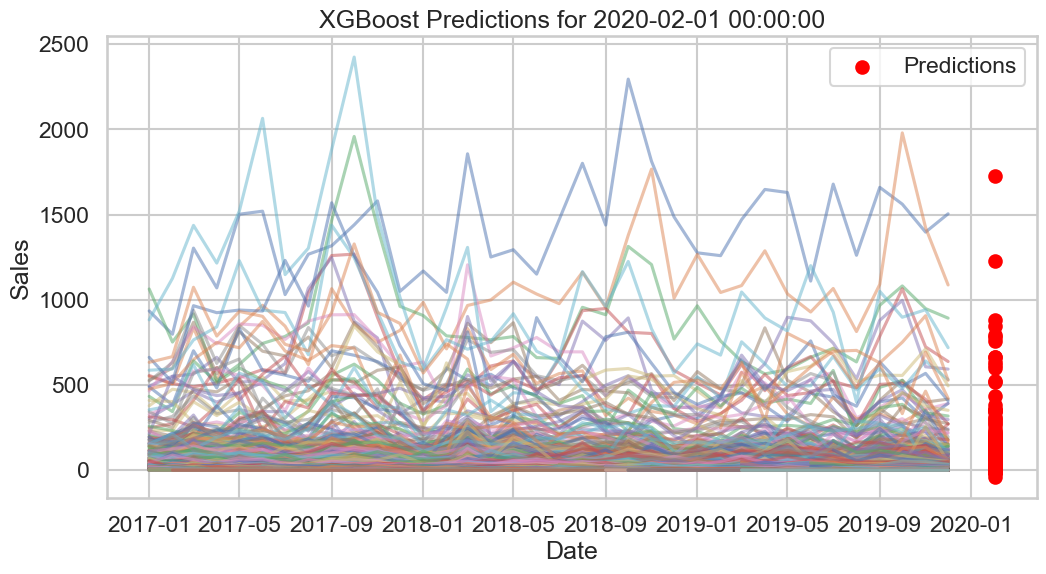

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Assuming data_grouped and features are already defined

def add_time_features(df):
    df['months_since_start'] = (df['periodo'] - df['periodo'].min()).dt.days // 30
    df['target_months_ahead'] = 2  # Since we're always predicting 2 months ahead
    return df

data_grouped = add_time_features(data_grouped)

def train_xgboost_model(X_train, y_train, X_val, y_val):
    model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              #eval_metric='rmse',
              #early_stopping_rounds=50,
              verbose=100)
    return model

def make_xgboost_predictions(model, data, target_date, products_to_predict):
    print("Target date:", target_date)
    print("Number of products to predict:", len(products_to_predict))
   
    # Get the last available date for each product
    last_dates = data.groupby('product_id')['periodo'].max().reset_index()
   
    # Prepare prediction data
    pred_data = []
    for _, row in last_dates.iterrows():
        product_data = data[(data['product_id'] == row['product_id']) & (data['periodo'] == row['periodo'])].copy()
        if not product_data.empty:
            product_data['months_since_start'] += 2  # Add 2 months for the prediction
            pred_data.append(product_data)
   
    pred_data = pd.concat(pred_data, ignore_index=True)
   
    print("Shape of pred_data:", pred_data.shape)
    print("Columns in pred_data:", pred_data.columns)
   
    if pred_data.empty:
        print("No data available for prediction")
        return pd.DataFrame(columns=['product_id', 'tn'])
   
    predictions = model.predict(pred_data[features])
    results = pd.DataFrame({
        'product_id': pred_data['product_id'],
        'tn': predictions
    })
    return results

def plot_predictions(data, predictions, target_date, model_name):
    plt.figure(figsize=(12, 6))
    
    # Plot actual data
    for product_id in predictions['product_id'].unique():
        product_data = data[data['product_id'] == product_id]
        plt.plot(product_data['periodo'], product_data['tn'], alpha=0.5)
    
    # Plot predictions
    plt.scatter([target_date] * len(predictions), predictions['tn'], color='red', label='Predictions')
    
    plt.title(f'{model_name} Predictions for {target_date}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# Assuming features list is defined, if not, define it here
features = [
    'tn_lag1', 'tn_lag2', 'tn_rolling_mean_3', 'tn_rolling_mean_6',
    'stock_final', 'cat1_avg_sales', 'cat2_avg_sales', 'cat3_avg_sales',
    'brand_avg_sales', 'size_avg_sales', 'sales_diff', 'sales_pct_change',
    'purchase_frequency', 'days_since_first_purchase', 'days_since_last_purchase',
    'year', 'month', 'months_since_start', 'target_months_ahead'
]
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
features_num= [col for col in numeric_columns if col != 'tn']
features=features_num

# Split the data for training and validation
train_data = data_grouped[data_grouped['periodo'] < '2019-11-01']
val_data = data_grouped[data_grouped['periodo'] >= '2019-11-01']

X_train, y_train = train_data[features], train_data['tn']
X_val, y_val = val_data[features], val_data['tn']

# Train the model
xgboost_model = train_xgboost_model(X_train, y_train, X_val, y_val)

# Make predictions
target_date = pd.to_datetime('2020-02-01')
xgboost_predictions = make_xgboost_predictions(xgboost_model, data_grouped, target_date, products_to_predict)

print("Shape of xgboost_predictions:", xgboost_predictions.shape)
print("Columns in xgboost_predictions:", xgboost_predictions.columns)
print("First few rows of xgboost_predictions:")
print(xgboost_predictions.head())

# Try to plot the predictions
plot_predictions(data_grouped, xgboost_predictions, target_date, 'XGBoost')

In [ ]:
data_monthly[data_monthly['product_id'] == 20001].copy()

,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size,...,cat1_avg_sales,cat2_avg_sales,cat3_avg_sales,brand_avg_sales,size_avg_sales,sales_diff,sales_pct_change,purchase_frequency,days_since_first_purchase,days_since_last_purchase
0,2017-01-01,20001,10001,99.43861,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.00000,0.000000,36,0,-1064
1,2017-01-01,20001,10002,35.72806,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.00000,0.000000,36,0,-1064
2,2017-01-01,20001,10003,143.49426,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.00000,0.000000,36,0,-1064
3,2017-01-01,20001,10004,184.72927,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.00000,0.000000,36,0,-1064
4,2017-01-01,20001,10005,19.08407,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.00000,0.000000,36,0,-1064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526552,2019-12-01,20001,10445,0.03361,69.75548,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,-0.01120,-0.249944,32,944,0
6526553,2019-12-01,20001,10452,0.12322,69.75548,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.12322,0.000000,32,944,0
6526554,2019-12-01,20001,10453,0.05601,69.75548,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.05601,0.000000,10,275,0
6526555,2019-12-01,20001,10481,0.03361,69.75548,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.03361,0.000000,11,303,0


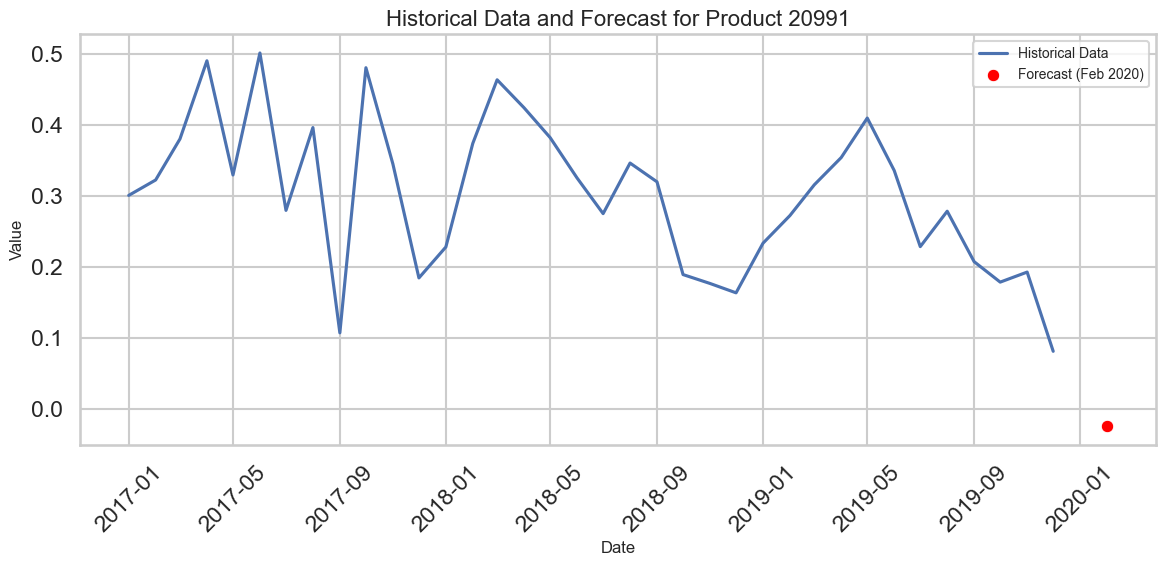

In [ ]:
# Load the data
data_monthly = data_grouped  # Assuming 'data' is your DataFrame
predictions = xgboost_predictions

# Filter data for product 20991
product_data = data_monthly[data_monthly['product_id'] == 21131].copy()
product_forecast = predictions[predictions['product_id'] == 21131].iloc[0]

# Convert 'periodo' to datetime
product_data['periodo'] = pd.to_datetime(product_data['periodo'])

# Sort data by date
product_data = product_data.sort_values('periodo')

# Create a DataFrame for the forecast (only February 2020)
forecast_data = pd.DataFrame({
    'periodo': [pd.to_datetime('2020-02-01')],
    'tn': [product_forecast['tn']]  # Using 'tn' which represents tn_202002
})

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot historical data
sns.lineplot(x='periodo', y='tn', data=product_data, label='Historical Data')

# Plot forecast
sns.scatterplot(x='periodo', y='tn', data=forecast_data, label='Forecast (Feb 2020)', color='red')

# Customize the plot
plt.title(f'Historical Data and Forecast for Product 20991', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:

# Save predictions
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'../predictions/xgboost_predictions_{current_datetime}.csv'
xgboost_predictions.to_csv(filename, index=False)

# LGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2393
[LightGBM] [Info] Number of data points in the train set: 20815, number of used features: 17
[LightGBM] [Info] Start training from score 54.252052
Shape of lightgbm_predictions: (780, 2)
Columns in lightgbm_predictions: Index(['product_id', 'tn'], dtype='object')
First few rows of lightgbm_predictions:
   product_id           tn
0       20001  1501.765368
1       20002  1177.595849
2       20003   911.589387
3       20004   839.693225
4       20005   803.569971


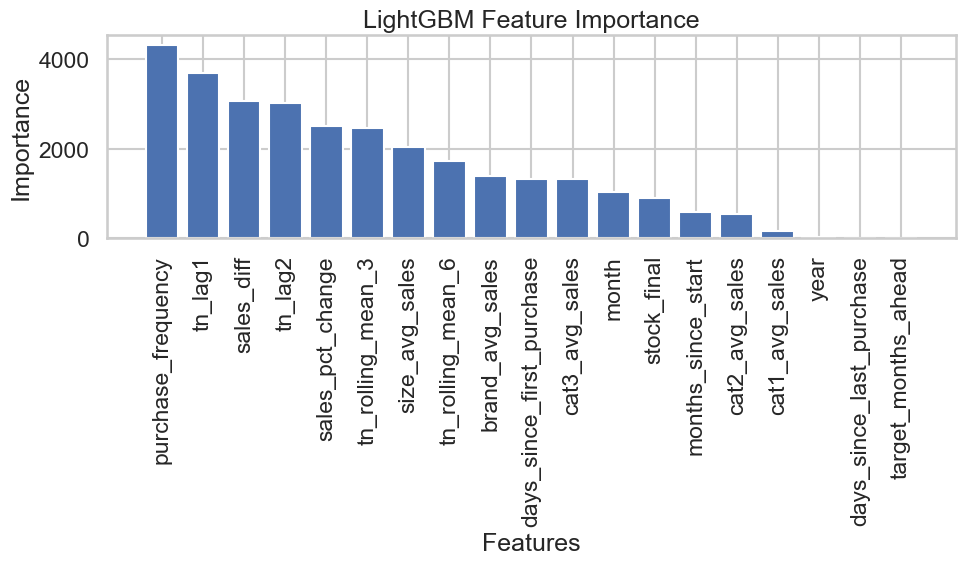

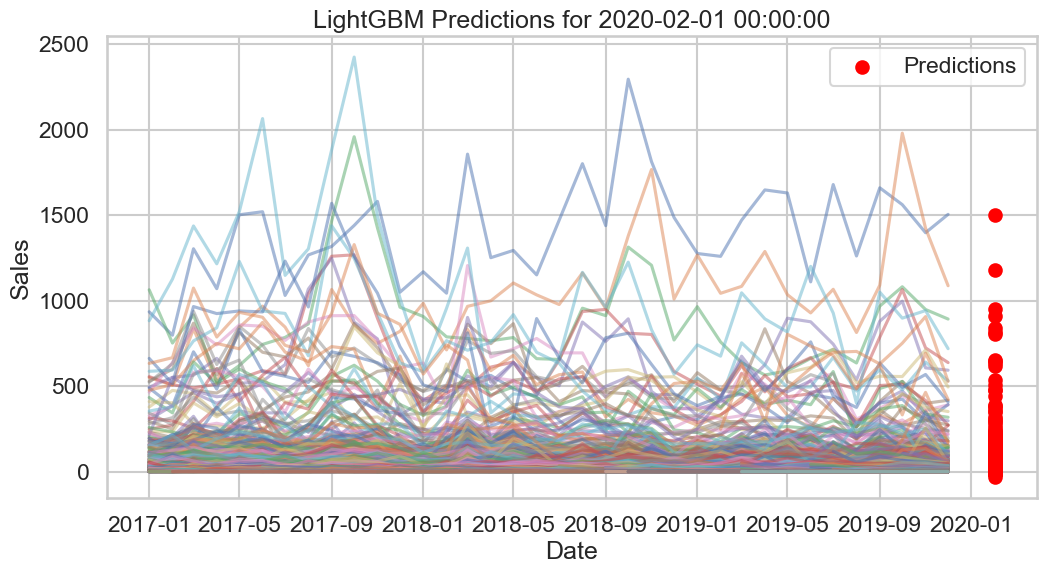

In [ ]:
from lightgbm import LGBMRegressor
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def train_lightgbm_model(X_train, y_train, X_val, y_val):
    model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31, random_state=42)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='mse',
              #early_stopping_rounds=50,
              #verbose=100
              )
    return model

def make_lightgbm_predictions(model, data, target_date, products_to_predict):
    # Get the last available date for each product
    last_dates = data.groupby('product_id')['periodo'].max().reset_index()
    
    # Prepare prediction data
    pred_data = []
    for _, row in products_to_predict.iterrows():
        product_id = row['product_id']
        last_date = last_dates[last_dates['product_id'] == product_id]['periodo'].iloc[0]
        product_data = data[(data['product_id'] == product_id) & (data['periodo'] == last_date)].copy()
        if not product_data.empty:
            # Update time-based features
            product_data['periodo'] = target_date
            product_data['months_since_start'] += (target_date - last_date).days // 30
            product_data['year'] = target_date.year
            product_data['month'] = target_date.month
            pred_data.append(product_data)
    
    pred_data = pd.concat(pred_data, ignore_index=True)
    
    if pred_data.empty:
        print("No data available for prediction")
        return pd.DataFrame(columns=['product_id', 'tn'])
    
    predictions = model.predict(pred_data[features])
    results = pd.DataFrame({
        'product_id': pred_data['product_id'],
        'tn': predictions
    })
    return results

def plot_feature_importance(model, features, model_name):
    feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'{model_name} Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_predictions(data, predictions, target_date, model_name):
    plt.figure(figsize=(12, 6))
    
    # Plot actual data
    for product_id in predictions['product_id'].unique():
        product_data = data[data['product_id'] == product_id]
        plt.plot(product_data['periodo'], product_data['tn'], alpha=0.5)
    
    # Plot predictions
    plt.scatter([target_date] * len(predictions), predictions['tn'], color='red', label='Predictions')
    
    plt.title(f'{model_name} Predictions for {target_date}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# Assuming data_grouped, features, X_train, y_train, X_val, y_val are already defined

# Train LightGBM model
lightgbm_model = train_lightgbm_model(X_train, y_train, X_val, y_val)

# Make predictions
target_date = pd.to_datetime('2020-02-01')
lightgbm_predictions = make_lightgbm_predictions(lightgbm_model, data_grouped, target_date, products_to_predict)

print("Shape of lightgbm_predictions:", lightgbm_predictions.shape)
print("Columns in lightgbm_predictions:", lightgbm_predictions.columns)
print("First few rows of lightgbm_predictions:")
print(lightgbm_predictions.head())

# Save predictions
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'../predictions/lightgbm_predictions_{current_datetime}.csv'
lightgbm_predictions.to_csv(filename, index=False)

# Plot feature importances
plot_feature_importance(lightgbm_model, features, 'LightGBM')

# Visualize predictions
plot_predictions(data_grouped, lightgbm_predictions, target_date, 'LightGBM')

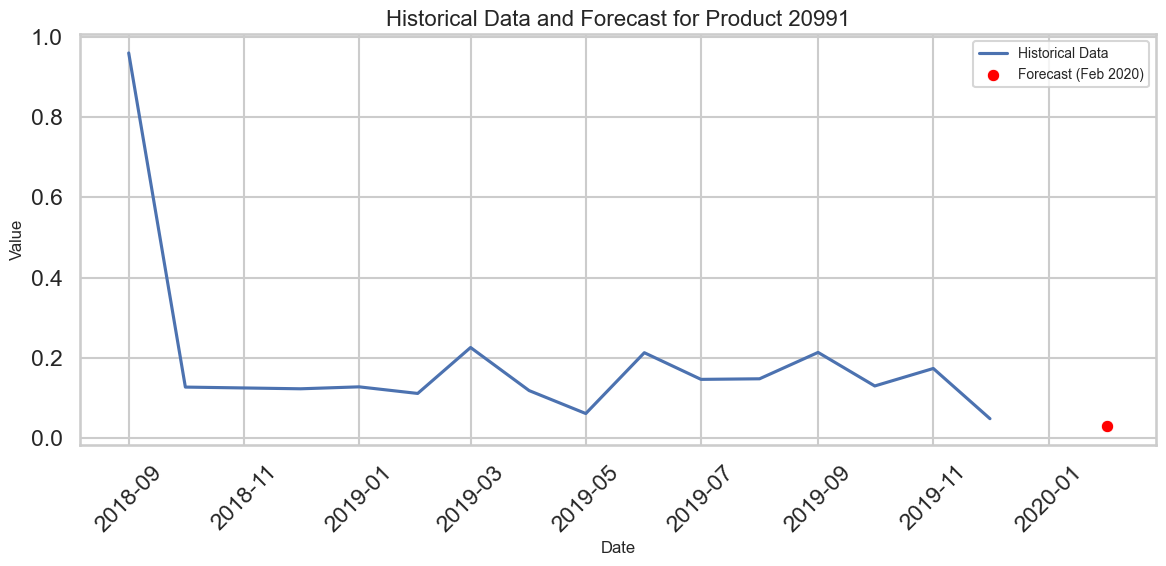

In [ ]:
# Load the data
data_monthly = data_grouped  # Assuming 'data' is your DataFrame
predictions = lightgbm_predictions

# Filter data for product 20991
product_data = data_monthly[data_monthly['product_id'] == 21226].copy()
product_forecast = predictions[predictions['product_id'] == 21226].iloc[0]

# Convert 'periodo' to datetime
product_data['periodo'] = pd.to_datetime(product_data['periodo'])

# Sort data by date
product_data = product_data.sort_values('periodo')

# Create a DataFrame for the forecast (only February 2020)
forecast_data = pd.DataFrame({
    'periodo': [pd.to_datetime('2020-02-01')],
    'tn': [product_forecast['tn']]  # Using 'tn' which represents tn_202002
})

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot historical data
sns.lineplot(x='periodo', y='tn', data=product_data, label='Historical Data')

# Plot forecast
sns.scatterplot(x='periodo', y='tn', data=forecast_data, label='Forecast (Feb 2020)', color='red')

# Customize the plot
plt.title(f'Historical Data and Forecast for Product 20991', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

LightGBM RMSE: 30.070343207315048
XGBoost RMSE: 27.23744450225929


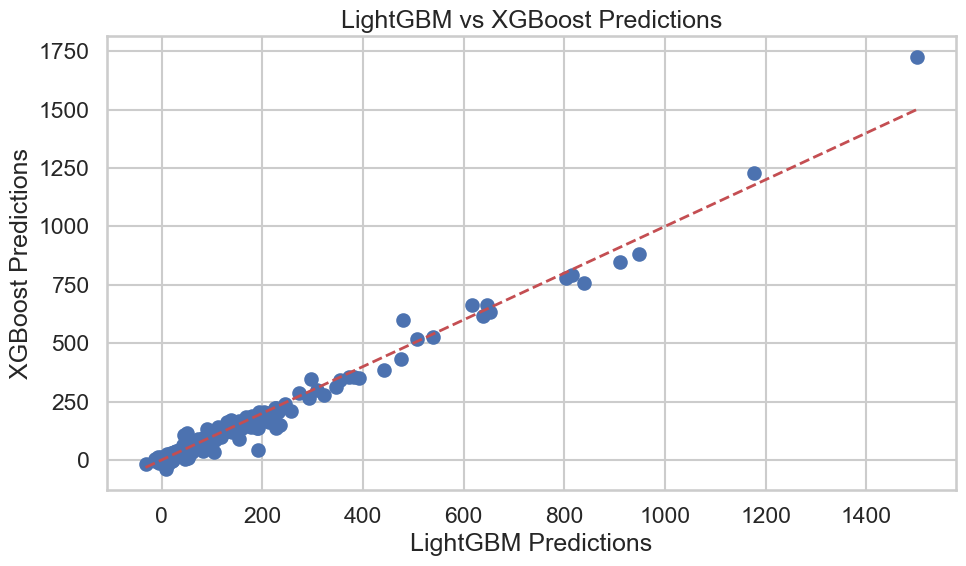

Summary of differences between LightGBM and XGBoost predictions:
count    780.000000
mean       1.097420
std       16.507836
min     -223.949110
25%       -1.148714
50%        0.008022
75%        1.511228
max      149.093067
Name: difference, dtype: float64


In [ ]:
def evaluate_model(model, X, y, model_name):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} RMSE: {rmse}")

# Evaluate on validation set
evaluate_model(lightgbm_model, X_val, y_val, "LightGBM")
evaluate_model(xgboost_model, X_val, y_val, "XGBoost")

# Compare predictions
comparison = pd.merge(lightgbm_predictions, xgboost_predictions, on='product_id', suffixes=('_lightgbm', '_xgboost'))
comparison['difference'] = comparison['tn_lightgbm'] - comparison['tn_xgboost']

plt.figure(figsize=(10, 6))
plt.scatter(comparison['tn_lightgbm'], comparison['tn_xgboost'])
plt.plot([comparison['tn_lightgbm'].min(), comparison['tn_lightgbm'].max()], 
         [comparison['tn_lightgbm'].min(), comparison['tn_lightgbm'].max()], 
         'r--', lw=2)
plt.xlabel('LightGBM Predictions')
plt.ylabel('XGBoost Predictions')
plt.title('LightGBM vs XGBoost Predictions')
plt.tight_layout()
plt.show()

print("Summary of differences between LightGBM and XGBoost predictions:")
print(comparison['difference'].describe())